# **Single class sensitivity analysis: what the classifying layer may show**

## Navigation

- [**Basic imports and initialization**](#Basic-imports-and-initialization)
- [**1. Alexnet**](#1.-Alexnet)
- [**2. VGG11**](#2.-VGG11)
- [**3. ResNet18**](#3.-ResNet18)

## Basic imports and initialization

$\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#1.-Alexnet)

- [Setting up templates, limiting the hardware resources, importing packages](#Setting-up-templates,-limiting-the-hardware-resources,-importing-packages)
- [Initializing common variables](#Initializing-common-variables)
- [Configuring experiments and generating corresponding sh-files](#Configuring-experiments-and-generating-corresponding-sh-files)

### Setting up templates, limiting the hardware resources, importing packages

$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Initializing-common-variables)

Select the template of config files. ```base``` is a standard one, ```slurm``` is intended for using on the clusters with slurm working manangement installed.

In [1]:
libstdcpp_path = ''

In the case of problems with loading ```libstc++.so.6```, please provide the path to the library. In any other case, just ignore the following block.

In [2]:
import ctypes

libstdcpp_path = '/mnt/bulky/pkharyuk/apd/envs/activation_sense/lib/libstdc++.so.6'
try:
    _stdcxx_lib = ctypes.cdll.LoadLibrary(libstdcpp_path)
except:
    pass

To provide easy access to modules stored in the ```../src/``` directory, we use the following workaround:

In [2]:
import sys
sys.path.append('../src/')

Next, we limit the hardware usage by setting the configuration dictionaries, maximum number of threads:

In [3]:
# set limitations on hardware
# fill on the template's config
import hardware_setup

mkl_num_threads = 4
hardware_setup.mkl_set_num_threads(num_threads=mkl_num_threads)

[mkl]: set up num_threads=4/4


Then we import all necessary packages:

In [4]:
import os
import functools

import numpy as np

import sensitivity_analysis.augmentation_setting
import preparation.single_unit
import prediction.compute
import prediction.single_class
import data_loader.imagenet

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

### Initializing common variables

[[$\leftarrow$Prev.subsect.]](#Setting-up-templates,-limiting-the-hardware-resources,-importing-packages)$\quad$[[Back to section]](#Basic-imports-and-initialization)$\quad$[[Next subsect.$\to$]](#Configuring-experiments-and-generating-corresponding-sh-files)

In [5]:
data_dirname = '../data/imagenet'

sensitivity_values_dirname = '../results/'
results_dirname = '../results/'

values_fnm_base = 'imagenet_ILSVRC_values'

no_aug_key = 'original'
y_true_key = 'true_labels'

n_round_digits = 4

alphas = [0., 0.5, 1.5]
percentiles = [0.5, 0.6, 0.7, 0.8, 0.9]
inverts = [0, 1]

augmentation_set_numbers_list = [1, 2]

n_top_values_decay_plot = 20
figsize_decay_plot = (10, 5)

In [6]:
ilsvrc_dataset = data_loader.imagenet.CustomImageNet(data_dirname, split='val')

In [7]:
shpv_group_indices_dict = {}
for aug_set_num in augmentation_set_numbers_list:
    shpv_group_indices_dict[
        aug_set_num
    ] = sensitivity_analysis.augmentation_setting.get_group_variables_indices(
        aug_set_num,
        use_permutation_variable=1,
        use_class_variable=1,
        use_partition_variable=1,
    )

sensitivity_values_name_list = [
    'shpv', 'si'
]
n_sens_vals = len(sensitivity_values_name_list)

augmentation_names_dict = preparation.single_unit.extract_augmentation_names_dict(
    augmentation_set_numbers_list,
    extract_auxilliary_names=False,
)
augmentation_names = functools.reduce(
    lambda x, y: x+y, augmentation_names_dict.values()
)

## 1. Alexnet

[[$\leftarrow$ Prev.part]](#Basic-imports-and-initialization) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#2.-VGG11)


- [1.1 Set up variables](#1.1-Set-up-variables)
- [1.2 Decay of the top sensitivity values](#1.2-Decay-of-the-top-sensitivity-values)
- [1.3 Top sensitivity values and corresponding classes](#1.3-Top-sensitivity-values-and-corresponding-classes)
- [1.4 Jaccard indices for top-5 predictions and top-5 sensitive classes](#1.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)
- [1.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes](#1.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

### 1.1 Set up variables

$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.2-Decay-of-the-top-sensitivity-values)

In [9]:
alexnet_network_name = 'alexnet'
alexnet_classifying_layer_name = 'classifier.6'

prediction_results_path_nofcl_list = [
    os.path.join(
        results_dirname, f'{val_name}_{alexnet_network_name}_{values_fnm_base}_pred_NOFCL_part=valid.hdf5'
    ) for val_name in sensitivity_values_name_list
]

alexnet_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    alexnet_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

alexnet_loaded_sensitivity_values_dict_list = []
for sensitivity_values_name in sensitivity_values_name_list:
    loaded_sensitivity_values_dict = prediction.compute.get_all_values(
        alexnet_values_fnms_dict,
        results_dirname,
        [alexnet_classifying_layer_name],
        sensitivity_values_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=False,
    )
    alexnet_loaded_sensitivity_values_dict_list.append(
        loaded_sensitivity_values_dict
    )

### 1.2 Decay of the top sensitivity values

[[$\leftarrow$Prev.subsect.]](#1.1-Set-up-variables)$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.3-Top-sensitivity-values-and-corresponding-classes)

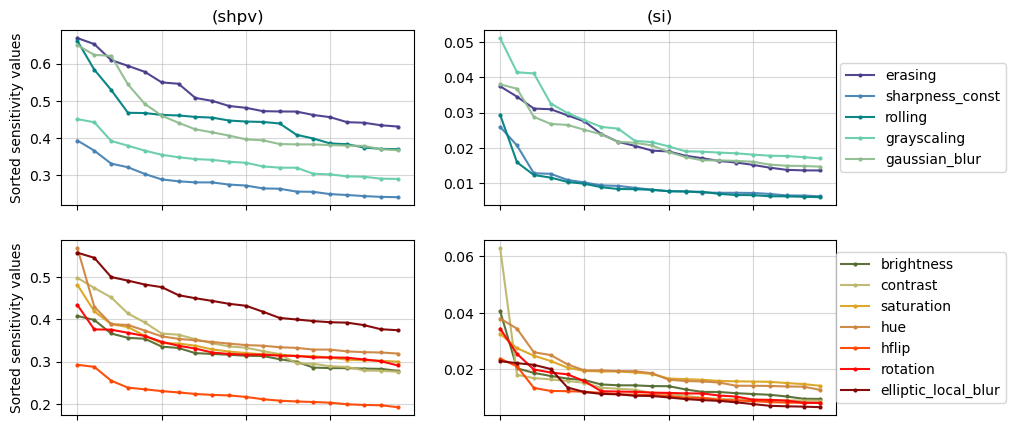

In [10]:
prediction.single_class.plot_top_sensitivity_values_decay(
    alexnet_loaded_sensitivity_values_dict_list,
    alexnet_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    n_top_values=n_top_values_decay_plot,
    figsize=figsize_decay_plot,
    extract_auxilliary_names=False,
    plot_colors=prediction.single_class._custom_colors[::-1],
    show=True,
)

### 1.3 Top sensitivity values and corresponding classes

[[$\leftarrow$Prev.subsect.]](#1.2-Decay-of-the-top-sensitivity-values)$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)

In [11]:
table_dict = prediction.single_class.extract_tables_top_sensitivity_values_decay(
    alexnet_loaded_sensitivity_values_dict_list,
    alexnet_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    ilsvrc_dataset.ind2class,
    n_top_values=10,
    extract_auxilliary_names=False,
)

In [12]:
for aug_name in augmentation_names:
    print(f'\n\t\t\t Augmentation: {aug_name}')
    display(table_dict[aug_name])


			 Augmentation: erasing


shpv                                                                si   
  class_id                                         class_name value class_id   
0      635                                   magnetic compass   .67      782  \
1       63                            Indian cobra, Naja naja   .65      664   
2       58                                        water snake   .61      851   
3      684                              ocarina, sweet potato   .59      711   
4      180  American Staffordshire terrier, Staffordshire ...   .58      876   
5      314                                   cockroach, roach   .55      583   
6      371           patas, hussar monkey, Erythrocebus patas   .55      907   
7      573                                            go-kart   .51      846   
8      641                                             maraca   .50      579   
9      279              Arctic fox, white fox, Alopex lagopus   .49      704   

                                        
                      class_name value  
0             screen, CRT screen   .04  
1                        monitor   .03  
2  television, television system   .03  
3               perfume, essence   .03  
4                       tub, vat   .03  
5                     guillotine   .03  
6                    wine bottle   .02  
7                     table lamp   .02  
8             grand piano, grand   .02  
9                  parking meter   .02


			 Augmentation: sharpness_const


shpv                                                                si   
  class_id                                         class_name value class_id   
0        6                                           stingray   .39      252  \
1       78                                               tick   .37      279   
2      354      Arabian camel, dromedary, Camelus dromedarius   .33      610   
3       33     loggerhead, loggerhead turtle, Caretta caretta   .32      246   
4      434                                         bath towel   .30      589   
5      908                                               wing   .29      383   
6      929               ice lolly, lolly, lollipop, popsicle   .28      890   
7      283                                        Persian cat   .28      209   
8      323  monarch, monarch butterfly, milkweed butterfly...   .28      687   
9      459                            brassiere, bra, bandeau   .28      216   

                                                            
                                          class_name value  
0         affenpinscher, monkey pinscher, monkey dog   .03  
1              Arctic fox, white fox, Alopex lagopus   .02  
2                         jersey, T-shirt, tee shirt   .01  
3                                         Great Dane   .01  
4  hand blower, blow dryer, blow drier, hair drye...   .01  
5     Madagascar cat, ring-tailed lemur, Lemur catta   .01  
6                                         volleyball   .01  
7                           Chesapeake Bay retriever   .01  
8                                  organ, pipe organ   .01  
9                           clumber, clumber spaniel   .01


			 Augmentation: rolling


shpv                                                                si   
  class_id                                         class_name value class_id   
0      935                                      mashed potato   .66       14  \
1      103  platypus, duckbill, duckbilled platypus, duck-...   .58      692   
2      719                             piggy bank, penny bank   .53      202   
3      676                                             muzzle   .47      833   
4      522                                       croquet ball   .47      822   
5       13                                    junco, snowbird   .46      688   
6      977                                  sandbar, sand bar   .46      249   
7      209                           Chesapeake Bay retriever   .46      505   
8      408                      amphibian, amphibious vehicle   .46      240   
9      936                                       head cabbage   .45      499   

                                                            
                                          class_name value  
0  indigo bunting, indigo finch, indigo bird, Pas...   .03  
1                                             packet   .02  
2                        soft-coated wheaten terrier   .01  
3                    submarine, pigboat, sub, U-boat   .01  
4                                         steel drum   .01  
5  oscilloscope, scope, cathode-ray oscilloscope,...   .01  
6               malamute, malemute, Alaskan malamute   .01  
7                                          coffeepot   .01  
8                                        Appenzeller   .01  
9                     cleaver, meat cleaver, chopper   .01


			 Augmentation: grayscaling


shpv                                                                si   
  class_id                                         class_name value class_id   
0       97                                              drake   .45      230  \
1      124             crayfish, crawfish, crawdad, crawdaddy   .44      743   
2      964                                             potpie   .39      252   
3       90                                           lorikeet   .38      424   
4       46                      green lizard, Lacerta viridis   .37      664   
5      852                                        tennis ball   .36      423   
6       20                                water ouzel, dipper   .35      583   
7      734  police van, police wagon, paddy wagon, patrol ...   .34      596   
8       53      ringneck snake, ring-necked snake, ring snake   .34      776   
9      931                                      bagel, beigel   .34      550   

                                                          
                                        class_name value  
0  Shetland sheepdog, Shetland sheep dog, Shetland   .05  
1                             prison, prison house   .04  
2       affenpinscher, monkey pinscher, monkey dog   .04  
3                                       barbershop   .03  
4                                          monitor   .03  
5                                     barber chair   .03  
6                                       guillotine   .03  
7                                          hatchet   .03  
8                                   sax, saxophone   .02  
9                                   espresso maker   .02


			 Augmentation: gaussian_blur


shpv                                                                si   
  class_id                                         class_name value class_id   
0      809                                          soup bowl   .65       47  \
1      431                                           bassinet   .62      438   
2      273             dingo, warrigal, warragal, Canis dingo   .62      562   
3      136            European gallinule, Porphyrio porphyrio   .54      907   
4      450                            bobsled, bobsleigh, bob   .49      229   
5      391  coho, cohoe, coho salmon, blue jack, silver sa...   .46      550   
6      120                                       fiddler crab   .44      876   
7      137  American coot, marsh hen, mud hen, water hen, ...   .42      503   
8      351                                         hartebeest   .42      252   
9      631                                             lotion   .41      294   

                                                     
                                   class_name value  
0     African chameleon, Chamaeleo chamaeleon   .04  
1                                      beaker   .04  
2                                    fountain   .03  
3                                 wine bottle   .03  
4               Old English sheepdog, bobtail   .03  
5                              espresso maker   .03  
6                                    tub, vat   .02  
7                             cocktail shaker   .02  
8  affenpinscher, monkey pinscher, monkey dog   .02  
9             brown bear, bruin, Ursus arctos   .02


			 Augmentation: brightness


shpv                                                      si   
  class_id                               class_name value class_id   
0      961                                    dough   .41      637  \
1      901                              whiskey jug   .40      178   
2      828                                 strainer   .37      834   
3      604                                hourglass   .36      317   
4      653                                 milk can   .35      831   
5       98  red-breasted merganser, Mergus serrator   .34      687   
6      596                                  hatchet   .33      562   
7      859                                  toaster   .32      767   
8      942                         butternut squash   .32      285   
9      209                 Chesapeake Bay retriever   .32       63   

                                               
                             class_name value  
0                   mailbox, letter box   .04  
1                            Weimaraner   .02  
2                 suit, suit of clothes   .02  
3                            leafhopper   .02  
4                 studio couch, day bed   .02  
5                     organ, pipe organ   .02  
6                              fountain   .01  
7  rubber eraser, rubber, pencil eraser   .01  
8                          Egyptian cat   .01  
9               Indian cobra, Naja naja   .01


			 Augmentation: contrast


shpv                                                                si   
  class_id                                         class_name value class_id   
0      171                                  Italian greyhound   .50       79  \
1      930                                        French loaf   .47      848   
2      529                              diaper, nappy, napkin   .45      902   
3      253                                            basenji   .41      750   
4      608                             jean, blue jean, denim   .39      513   
5      394                                           sturgeon   .37      806   
6      557                                flagpole, flagstaff   .36      488   
7      784                                        screwdriver   .35      888   
8       49  African crocodile, Nile crocodile, Crocodylus ...   .34       90   
9      162                                             beagle   .34      791   

                                          
                        class_name value  
0                        centipede   .06  
1                      tape player   .02  
2                          whistle   .02  
3  quilt, comforter, comfort, puff   .02  
4     cornet, horn, trumpet, trump   .02  
5                             sock   .02  
6                            chain   .01  
7                          viaduct   .01  
8                         lorikeet   .01  
9                    shopping cart   .01


			 Augmentation: saturation


shpv                                        si   
  class_id                 class_name value class_id   
0      597                    holster   .48      671  \
1      914                       yawl   .42      384   
2      712                 Petri dish   .39      723   
3      274        dhole, Cuon alpinus   .38      416   
4      278   kit fox, Vulpes macrotis   .36      410   
5      880        unicycle, monocycle   .34      596   
6      150                   sea lion   .34      996   
7      617  lab coat, laboratory coat   .34      385   
8      419                   Band Aid   .33      328   
9      908                       wing   .32      781   

                                                            
                                          class_name value  
0        mountain bike, all-terrain bike, off-roader   .03  
1    indri, indris, Indri indri, Indri brevicaudatus   .03  
2                                           pinwheel   .02  
3                                 balance beam, beam   .02  
4                                  apiary, bee house   .02  
5                                            hatchet   .02  
6  hen-of-the-woods, hen of the woods, Polyporus ...   .02  
7                   Indian elephant, Elephas maximus   .02  
8                                         sea urchin   .02  
9                                         scoreboard   .02


			 Augmentation: hue


shpv                                                                si   
  class_id                                         class_name value class_id   
0      977                                  sandbar, sand bar   .57      178  \
1      163                            bloodhound, sleuthhound   .43      992   
2      242                                              boxer   .39      151   
3       64                                        green mamba   .39       17   
4      164                                           bluetick   .37      317   
5      118                    Dungeness crab, Cancer magister   .36      309   
6      508                          computer keyboard, keypad   .35      960   
7      932                                            pretzel   .35      737   
8       66  horned viper, cerastes, sand viper, horned asp...   .35      517   
9      996  hen-of-the-woods, hen of the woods, Polyporus ...   .34       46   

                                           
                         class_name value  
0                        Weimaraner   .04  
1                            agaric   .03  
2                         Chihuahua   .03  
3                               jay   .03  
4                        leafhopper   .02  
5                               bee   .02  
6  chocolate sauce, chocolate syrup   .02  
7           pop bottle, soda bottle   .02  
8                             crane   .02  
9     green lizard, Lacerta viridis   .02


			 Augmentation: hflip


shpv                                                                si   
  class_id                                         class_name value class_id   
0      676                                             muzzle   .29      657  \
1      273             dingo, warrigal, warragal, Canis dingo   .29      197   
2      294                    brown bear, bruin, Ursus arctos   .25      801   
3      690                                             oxcart   .24      776   
4      140        red-backed sandpiper, dunlin, Erolia alpina   .23      744   
5      731                          plunger, plumber's helper   .23      787   
6      391  coho, cohoe, coho salmon, blue jack, silver sa...   .23       94   
7      678                                         neck brace   .22      231   
8      627                                    limousine, limo   .22      672   
9      138                                            bustard   .22      491   

                              
            class_name value  
0              missile   .02  
1      giant schnauzer   .02  
2              snorkel   .01  
3       sax, saxophone   .01  
4  projectile, missile   .01  
5      shield, buckler   .01  
6          hummingbird   .01  
7               collie   .01  
8        mountain tent   .01  
9  chain saw, chainsaw   .01


			 Augmentation: rotation


shpv                                                                si   
  class_id                                         class_name value class_id   
0      807         solar dish, solar collector, solar furnace   .43      529  \
1      460  breakwater, groin, groyne, mole, bulwark, seaw...   .38      317   
2      201                        silky terrier, Sydney silky   .38      743   
3      870                        tricycle, trike, velocipede   .37      194   
4      161                               basset, basset hound   .36      558   
5      967                                           espresso   .35      450   
6      348                                           ram, tup   .34      850   
7       78                                               tick   .33      745   
8      875                                           trombone   .32      888   
9      373                                            macaque   .32      898   

                                                 
                               class_name value  
0                   diaper, nappy, napkin   .03  
1                              leafhopper   .03  
2                    prison, prison house   .02  
3  Dandie Dinmont, Dandie Dinmont terrier   .02  
4                 flute, transverse flute   .02  
5                 bobsled, bobsleigh, bob   .02  
6                       teddy, teddy bear   .01  
7                               projector   .01  
8                                 viaduct   .01  
9                            water bottle   .01


			 Augmentation: elliptic_local_blur


shpv                                                                si   
  class_id                                         class_name value class_id   
0      344  hippopotamus, hippo, river horse, Hippopotamus...   .56      575  \
1      220                                     Sussex spaniel   .55      817   
2      280       grey fox, gray fox, Urocyon cinereoargenteus   .50      433   
3      146                               albatross, mollymawk   .49      932   
4      673                              mouse, computer mouse   .48      597   
5      234                                         Rottweiler   .48      584   
6      927                                             trifle   .46      862   
7      842                    swimming trunks, bathing trunks   .45      802   
8      969                                             eggnog   .44      427   
9      442                                bell cote, bell cot   .44      641   

                                    
                  class_name value  
0        golfcart, golf cart   .02  
1      sports car, sport car   .02  
2  bathing cap, swimming cap   .02  
3                    pretzel   .02  
4                    holster   .01  
5                 hair slide   .01  
6                      torch   .01  
7                 snowmobile   .01  
8               barrel, cask   .01  
9                     maraca   .01

### 1.4 Jaccard indices for top-5 predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#1.3-Top-sensitivity-values-and-corresponding-classes)$\quad$[[Back to section]](#1.-Alexnet)$\quad$[[Next subsect.$\to$]](#1.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

In [14]:
alexnet_sensitivity_topn_list = prediction.single_class.get_sensitivity_topn_dict(
    alexnet_loaded_sensitivity_values_dict_list,
    alexnet_classifying_layer_name,
    augmentation_set_numbers_list,
    top_n=5,
    extract_auxilliary_names=False,
)

alexnet_results_jacc_nofcl_list = []
alexnet_results_jacc_aug_no_mask_list = []
alexnet_results_jacc_orig_no_mask_list = []

for i in range(n_sens_vals):
    (
        alexnet_results_jacc, 
        alexnet_results_jacc_aug_no_mask,
        alexnet_results_jacc_orig_no_mask,
    ) = prediction.single_class.extract_jaccard(
        prediction_results_path_nofcl_list[i],
        alexnet_sensitivity_topn_list[i],
        augmentation_names,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
    )
    alexnet_results_jacc_nofcl_list.append(alexnet_results_jacc)
    alexnet_results_jacc_aug_no_mask_list.append(alexnet_results_jacc_aug_no_mask)
    alexnet_results_jacc_orig_no_mask_list.append(alexnet_results_jacc_orig_no_mask)

Nsamples=50000
Nsamples=50000


In [15]:
for i_val, val_name in enumerate(sensitivity_values_name_list):
    table_jac_no_masking = prediction.single_class.extract_table_no_masking(
        alexnet_results_jacc_aug_no_mask_list[i_val],
        alexnet_results_jacc_orig_no_mask_list[i_val],
        augmentation_set_numbers_list,
        extract_auxilliary_names=False,
        n_round_digits=n_round_digits,
        no_aug_key=no_aug_key,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table_jac_no_masking)



				shpv


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0029                                     \
erasing                                                           0.0016                                      
sharpness_const                                                   0.0030                                      
rolling                                                           0.0026                                      
grayscaling                                                       0.0019                                      
gaussian_blur                                                     0.0033                                      
brightness                                                        0.0027                                      
contrast                                                          0.0023                                      
saturation                                                        0.0026                                      
hue                                                               0.0028                                      
hflip                                                             0.0030                                      
rotation                                                          0.0029                                      
elliptic_local_blur                                               0.0028                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0026  0.0021      0.0028        0.0030  \
erasing                        0.0018  0.0017      0.0021        0.0022   
sharpness_const                0.0027  0.0020      0.0029        0.0028   
rolling                        0.0023  0.0018      0.0028        0.0027   
grayscaling                    0.0022  0.0011      0.0010        0.0016   
gaussian_blur                  0.0024  0.0032      0.0024        0.0030   
brightness                     0.0024  0.0021      0.0029        0.0028   
contrast                       0.0020  0.0018      0.0031        0.0028   
saturation                     0.0025  0.0021      0.0044        0.0029   
hue                            0.0028  0.0019      0.0031        0.0021   
hflip                          0.0025  0.0021      0.0028        0.0029   
rotation                       0.0031  0.0024      0.0029        0.0032   
elliptic_local_blur            0.0026  0.0023      0.0029        0.0029   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0022   0.0028     0.0025  0.0028  0.0025   0.0033  \
erasing                   0.0015   0.0024     0.0019  0.0020  0.0023   0.0032   
sharpness_const           0.0022   0.0027     0.0025  0.0028  0.0025   0.0034   
rolling                   0.0020   0.0028     0.0023  0.0026  0.0025   0.0032   
grayscaling               0.0053   0.0014     0.0018  0.0033  0.0017   0.0047   
gaussian_blur             0.0026   0.0029     0.0031  0.0032  0.0032   0.0028   
brightness                0.0019   0.0025     0.0022  0.0026  0.0024   0.0030   
contrast                  0.0019   0.0023     0.0019  0.0022  0.0024   0.0031   
saturation                0.0022   0.0024     0.0025  0.0025  0.0022   0.0032   
hue                       0.0019   0.0026     0.0018  0.0021  0.0013   0



				si


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0036                                     \
erasing                                                           0.0162                                      
sharpness_const                                                   0.0036                                      
rolling                                                           0.0040                                      
grayscaling                                                       0.0048                                      
gaussian_blur                                                     0.0028                                      
brightness                                                        0.0039                                      
contrast                                                          0.0044                                      
saturation                                                        0.0040                                      
hue                                                               0.0053                                      
hflip                                                             0.0036                                      
rotation                                                          0.0020                                      
elliptic_local_blur                                               0.0038                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0024  0.0028      0.0031        0.0026  \
erasing                        0.0024  0.0038      0.0071        0.0036   
sharpness_const                0.0024  0.0029      0.0031        0.0025   
rolling                        0.0024  0.0032      0.0038        0.0031   
grayscaling                    0.0037  0.0030      0.0063        0.0044   
gaussian_blur                  0.0027  0.0030      0.0032        0.0029   
brightness                     0.0024  0.0029      0.0028        0.0030   
contrast                       0.0021  0.0026      0.0030        0.0037   
saturation                     0.0024  0.0030      0.0032        0.0031   
hue                            0.0037  0.0027      0.0036        0.0056   
hflip                          0.0024  0.0027      0.0032        0.0026   
rotation                       0.0025  0.0033      0.0027        0.0026   
elliptic_local_blur            0.0026  0.0028      0.0032        0.0028   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0026   0.0032     0.0025  0.0027  0.0036   0.0029  \
erasing                   0.0052   0.0027     0.0030  0.0025  0.0032   0.0025   
sharpness_const           0.0026   0.0034     0.0022  0.0026  0.0037   0.0025   
rolling                   0.0026   0.0030     0.0032  0.0026  0.0036   0.0026   
grayscaling               0.0038   0.0037     0.0013  0.0033  0.0048   0.0029   
gaussian_blur             0.0022   0.0036     0.0046  0.0023  0.0030   0.0039   
brightness                0.0025   0.0034     0.0031  0.0029  0.0038   0.0025   
contrast                  0.0022   0.0032     0.0029  0.0028  0.0040   0.0023   
saturation                0.0028   0.0035     0.0034  0.0030  0.0034   0.0027   
hue                       0.0032   0.0034     0.0030  0.0036  0.0038   0

### 1.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#1.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)$\quad$[[Back to section]](#1.-Alexnet)$\quad$

In [16]:
for i_val, val_name in enumerate(sensitivity_values_name_list):
    featured_measurements, _ = prediction.single_class.collect_featured_measurements_jac(
        alexnet_results_jacc_nofcl_list[i_val],
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        no_aug_key=no_aug_key,
    )
    table = prediction.single_class.extract_table_self_masking(
        featured_measurements,
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        n_round_digits=n_round_digits,
        extract_auxilliary_names=False,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table)



				shpv


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0196            \
sharpness_const                                                   0.0000             
rolling                                                           0.0000             
grayscaling                                                       0.0000             
gaussian_blur                                                     0.0009             
brightness                                                        0.0000             
contrast                                                          0.0240             
saturation                                                        0.0252             
hue                                                               0.0000             
hflip                                                             0.0002             
rotation                                                          0.0002             
elliptic_local_blur                                               0.0005             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0187  0.0126  0.0079  0.0045    0.0033  0.0032  \
sharpness_const        0.0002  0.0007  0.0011  0.0023    0.0019  0.0020   
rolling                0.0000  0.0004  0.0009  0.0019    0.0012  0.0014   
grayscaling            0.0000  0.0000  0.0011  0.0007    0.0001  0.0002   
gaussian_blur          0.0017  0.0029  0.0031  0.0036    0.0045  0.0041   
brightness             0.0001  0.0005  0.0014  0.0020    0.0019  0.0019   
contrast               0.0223  0.0219  0.0097  0.0034    0.0059  0.0049   
saturation             0.0171  0.0097  0.0049  0.0031    0.0049  0.0036   
hue                    0.0000  0.0006  0.0016  0.0009    0.0007  0.0012   
hflip                  0.0004  0.0005  0.0005  0.0017    0.0024  0.0025   
rotation               0.0004  0.0010  0.0019  0.0026    0.0013  0.0017   
elliptic_local_blur    0.0002  0.0005  0.0011  0.0020    0.0019  0.0019   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0032  0.0031  0.0028    0.0004  0.0003  0.0002  \
sharpness_const        0.0022  0.0025  0.0027    0.0017  0.0018  0.0019   
rolling                0.0017  0.0019  0.0020    0.0020  0.0021  0.0020   
grayscaling            0.0005  0.0011  0.0007    0.0008  0.0007  0.0007   
gaussian_blur          0.0038  0.0037  0.0038    0.0014  0.0017  0.0017   
brightness             0.0021  0.0021  0.0020    0.0013  0.0013  0.0015   
contrast               0.0041  0.0033  0.0027    0.0015  0.0015  0.0016   
saturation             0.0033  0.0034  0.0030    0.0013  0.0014  0.0013   
hue                    0.0015  0.0014  0.0016    0.0014  0.0013  0.0012   
hflip                  0.0025  0.0026  0.0027    0.0019  0.0020  0.0023   
rotation               0.0022  0.0026  0.0028    0.0028  0.0029  0.0031   
elliptic_local_blur    0.0022  0.0024  0.0025    0.0026  0.0028  0.0031   

                                                     
                                      inv=0   inv=1  
                        q=0.8   q=0.9                
Augmentation of input                                
erasing                0.00



				si


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0000            \
sharpness_const                                                   0.0000             
rolling                                                           0.0111             
grayscaling                                                       0.0002             
gaussian_blur                                                     0.0004             
brightness                                                        0.0008             
contrast                                                          0.0001             
saturation                                                        0.0000             
hue                                                               0.0001             
hflip                                                             0.0012             
rotation                                                          0.0002             
elliptic_local_blur                                               0.0124             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0001  0.0003  0.0005  0.0009    0.0008  0.0009  \
sharpness_const        0.0011  0.0015  0.0020  0.0024    0.0026  0.0023   
rolling                0.0054  0.0047  0.0045  0.0028    0.0037  0.0034   
grayscaling            0.0022  0.0040  0.0044  0.0041    0.0056  0.0054   
gaussian_blur          0.0021  0.0049  0.0048  0.0034    0.0043  0.0041   
brightness             0.0014  0.0020  0.0020  0.0021    0.0017  0.0017   
contrast               0.0002  0.0012  0.0041  0.0042    0.0035  0.0035   
saturation             0.0002  0.0006  0.0024  0.0020    0.0013  0.0015   
hue                    0.0007  0.0025  0.0031  0.0031    0.0045  0.0040   
hflip                  0.0066  0.0091  0.0077  0.0047    0.0048  0.0047   
rotation               0.0007  0.0015  0.0032  0.0043    0.0044  0.0045   
elliptic_local_blur    0.0088  0.0070  0.0040  0.0030    0.0031  0.0031   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0011  0.0014  0.0023    0.0704  0.0851  0.0959  \
sharpness_const        0.0024  0.0024  0.0024    0.0018  0.0020  0.0022   
rolling                0.0032  0.0029  0.0027    0.0038  0.0043  0.0048   
grayscaling            0.0053  0.0051  0.0048    0.0056  0.0057  0.0056   
gaussian_blur          0.0040  0.0038  0.0031    0.0021  0.0022  0.0023   
brightness             0.0019  0.0020  0.0022    0.0023  0.0023  0.0023   
contrast               0.0036  0.0039  0.0037    0.0051  0.0058  0.0064   
saturation             0.0015  0.0020  0.0022    0.0115  0.0140  0.0157   
hue                    0.0036  0.0035  0.0031    0.0028  0.0029  0.0029   
hflip                  0.0044  0.0043  0.0039    0.0026  0.0028  0.0029   
rotation               0.0045  0.0045  0.0044    0.0023  0.0024  0.0026   
elliptic_local_blur    0.0031  0.0029  0.0028    0.0026  0.0027  0.0030   

                                                     
                                      inv=0   inv=1  
                        q=0.8   q=0.9                
Augmentation of input                                
erasing                0.10

## 2. VGG11

[[$\leftarrow$ Prev.part]](#1.-Alexnet) $\qquad$ [[Back to top]](#Navigation) $\qquad$ [[Next part $\to$]](#3.-ResNet18)

- [2.1 Set up variables](#2.1-Set-up-variables)
- [2.2 Decay of the top sensitivity values](#2.2-Decay-of-the-top-sensitivity-values)
- [2.3 Top sensitivity values and corresponding classes](#2.3-Top-sensitivity-values-and-corresponding-classes)
- [2.4 Jaccard indices for top-5 predictions and top-5 sensitive classes](#2.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)
- [2.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes](#2.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

### 2.1 Set up variables

$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.2-Decay-of-the-top-sensitivity-values)

In [17]:
vgg11_network_name = 'vgg11'
vgg11_classifying_layer_name = 'classifier.6'

prediction_results_path_nofcl_list = [
    os.path.join(
        results_dirname, f'{val_name}_{vgg11_network_name}_{values_fnm_base}_pred_NOFCL_part=valid.hdf5'
    ) for val_name in sensitivity_values_name_list
]

vgg11_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    vgg11_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

vgg11_loaded_sensitivity_values_dict_list = []
for sensitivity_values_name in sensitivity_values_name_list:
    loaded_sensitivity_values_dict = prediction.compute.get_all_values(
        vgg11_values_fnms_dict,
        results_dirname,
        [vgg11_classifying_layer_name],
        sensitivity_values_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=False,
    )
    vgg11_loaded_sensitivity_values_dict_list.append(
        loaded_sensitivity_values_dict
    )

### 2.2 Decay of the top sensitivity values

[[$\leftarrow$Prev.subsect.]](#2.1-Set-up-variables)$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.3-Top-sensitivity-values-and-corresponding-classes)

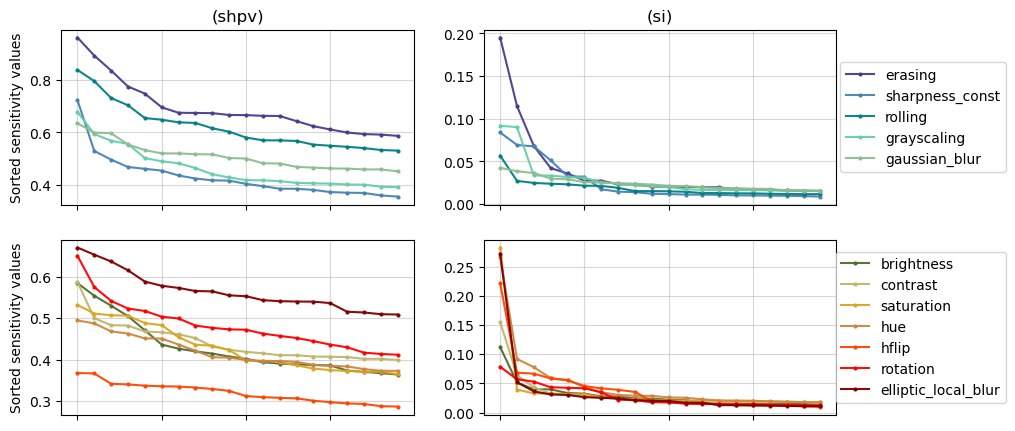

In [18]:
prediction.single_class.plot_top_sensitivity_values_decay(
    vgg11_loaded_sensitivity_values_dict_list,
    vgg11_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    n_top_values=n_top_values_decay_plot,
    figsize=figsize_decay_plot,
    extract_auxilliary_names=False,
    plot_colors=prediction.single_class._custom_colors[::-1],
    show=True,
)

### 2.3 Top sensitivity values and corresponding classes

[[$\leftarrow$Prev.subsect.]](#2.2-Decay-of-the-top-sensitivity-values)$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)

In [19]:
vgg11_table_dict = prediction.single_class.extract_tables_top_sensitivity_values_decay(
    vgg11_loaded_sensitivity_values_dict_list,
    vgg11_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    ilsvrc_dataset.ind2class,
    n_top_values=10,
    extract_auxilliary_names=False,
)

In [20]:
# recomptued
for aug_name in augmentation_names:
    print(f'\n\t\t\t Augmentation: {aug_name}')
    display(vgg11_table_dict[aug_name])


			 Augmentation: erasing


shpv                                                                si   
  class_id                                         class_name value class_id   
0      452                                bonnet, poke bonnet   .96       31  \
1      211                          vizsla, Hungarian pointer   .89      343   
2       79                                          centipede   .84       44   
3      831                              studio couch, day bed   .77      390   
4      127                       white stork, Ciconia ciconia   .75      285   
5      620                            laptop, laptop computer   .70      444   
6      853                              thatch, thatched roof   .67      771   
7      747  punching bag, punch bag, punching ball, punchball   .67      747   
8      842                    swimming trunks, bathing trunks   .67      851   
9      217         English springer, English springer spaniel   .67      427   

                                                            
                                          class_name value  
0                               tree frog, tree-frog   .20  
1                                            warthog   .11  
2                                   alligator lizard   .07  
3                                                eel   .04  
4                                       Egyptian cat   .04  
5      bicycle-built-for-two, tandem bicycle, tandem   .03  
6                                               safe   .03  
7  punching bag, punch bag, punching ball, punchball   .02  
8                      television, television system   .02  
9                                       barrel, cask   .02


			 Augmentation: sharpness_const


shpv                                                                si   
  class_id                                         class_name value class_id   
0      929               ice lolly, lolly, lollipop, popsicle   .72      126  \
1      852                                        tennis ball   .53      343   
2      674                                          mousetrap   .50      391   
3      259                                         Pomeranian   .47      427   
4      137  American coot, marsh hen, mud hen, water hen, ...   .46      249   
5      470                           candle, taper, wax light   .46      859   
6      348                                           ram, tup   .44      503   
7      435                    bathtub, bathing tub, bath, tub   .43      904   
8      921  book jacket, dust cover, dust jacket, dust wra...   .42      966   
9      926                                    hot pot, hotpot   .42      478   

                                                            
                                          class_name value  
0                                             isopod   .08  
1                                            warthog   .07  
2  coho, cohoe, coho salmon, blue jack, silver sa...   .07  
3                                       barrel, cask   .05  
4               malamute, malemute, Alaskan malamute   .03  
5                                            toaster   .03  
6                                    cocktail shaker   .02  
7                                      window screen   .01  
8                                           red wine   .01  
9                                             carton   .01


			 Augmentation: rolling


shpv                                                        si   
  class_id                                 class_name value class_id   
0        6                                   stingray   .84       80  \
1      193                         Australian terrier   .80      652   
2      965                                    burrito   .73      975   
3      199  Scotch terrier, Scottish terrier, Scottie   .70      582   
4      389                          barracouta, snoek   .65      974   
5      419                                   Band Aid   .65      858   
6      976       promontory, headland, head, foreland   .64      687   
7      478                                     carton   .64      420   
8      997                                     bolete   .62      282   
9      922                                       menu   .60      876   

                                                      
                                    class_name value  
0                                 black grouse   .06  
1                             military uniform   .03  
2                          lakeside, lakeshore   .02  
3  grocery store, grocery, food market, market   .02  
4                                       geyser   .02  
5                                    tile roof   .02  
6                            organ, pipe organ   .02  
7                                        banjo   .02  
8                                    tiger cat   .02  
9                                     tub, vat   .01


			 Augmentation: grayscaling


shpv                                                                si   
  class_id                                         class_name value class_id   
0      392                  rock beauty, Holocanthus tricolor   .68       31  \
1      122  American lobster, Northern lobster, Maine lobs...   .59      343   
2      639                                 maillot, tank suit   .57      600   
3       49  African crocodile, Nile crocodile, Crocodylus ...   .56      287   
4      125                                        hermit crab   .50      743   
5      226                                             briard   .49      169   
6      107                                          jellyfish   .48       39   
7      109                                        brain coral   .46      193   
8      925                                           consomme   .44      788   
9      300                                       tiger beetle   .43      651   

                                               
                             class_name value  
0                  tree frog, tree-frog   .09  
1                               warthog   .09  
2                            hook, claw   .03  
3                       lynx, catamount   .03  
4                  prison, prison house   .03  
5             borzoi, Russian wolfhound   .03  
6  common iguana, iguana, Iguana iguana   .03  
7                    Australian terrier   .02  
8      shoe shop, shoe-shop, shoe store   .02  
9             microwave, microwave oven   .02


			 Augmentation: gaussian_blur


shpv                                                                si   
  class_id                                         class_name value class_id   
0      588                                             hamper   .63      314  \
1      709                            pencil box, pencil case   .60      205   
2      623             letter opener, paper knife, paperknife   .60      910   
3      934                           hotdog, hot dog, red hot   .55      651   
4      595                                  harvester, reaper   .53       44   
5      672                                      mountain tent   .52      889   
6      975                                lakeside, lakeshore   .52      500   
7      455                                          bottlecap   .52      971   
8      388  giant panda, panda, panda bear, coon bear, Ail...   .52      743   
9      885                                             velvet   .50      378   

                                              
                            class_name value  
0                     cockroach, roach   .04  
1                flat-coated retriever   .04  
2                         wooden spoon   .04  
3            microwave, microwave oven   .03  
4                     alligator lizard   .03  
5                       violin, fiddle   .03  
6                       cliff dwelling   .02  
7                               bubble   .02  
8                 prison, prison house   .02  
9  capuchin, ringtail, Cebus capucinus   .02


			 Augmentation: brightness


shpv                                                                si   
  class_id                                         class_name value class_id   
0        4                       hammerhead, hammerhead shark   .58      181  \
1      758                                               reel   .55      701   
2      495                        china cabinet, china closet   .53      375   
3      379                              howler monkey, howler   .50      178   
4      912  worm fence, snake fence, snake-rail fence, Vir...   .47      427   
5      862                                              torch   .44      983   
6      923                                              plate   .43      723   
7      939                                zucchini, courgette   .42      125   
8      869                                        trench coat   .41      920   
9       26                     common newt, Triturus vulgaris   .41      927   

                                                   
                                 class_name value  
0                        Bedlington terrier   .11  
1                          parachute, chute   .05  
2                   colobus, colobus monkey   .04  
3                                Weimaraner   .04  
4                              barrel, cask   .03  
5                               scuba diver   .03  
6                                  pinwheel   .03  
7                               hermit crab   .03  
8  traffic light, traffic signal, stoplight   .02  
9                                    trifle   .02


			 Augmentation: contrast


shpv                                                                si   
  class_id                                         class_name value class_id   
0      993                                          gyromitra   .59      500  \
1      326                       lycaenid, lycaenid butterfly   .50      513   
2      887                                           vestment   .48      611   
3      704                                      parking meter   .48      862   
4      611                                      jigsaw puzzle   .47      806   
5      891                                        waffle iron   .47      172   
6        2  great white shark, white shark, man-eater, man...   .46      875   
7      969                                             eggnog   .45      289   
8      215                                   Brittany spaniel   .43      406   
9      568                                           fur coat   .42      421   

                                                            
                                          class_name value  
0                                     cliff dwelling   .15  
1                       cornet, horn, trumpet, trump   .06  
2                                      jigsaw puzzle   .04  
3                                              torch   .03  
4                                               sock   .03  
5                                            whippet   .03  
6                                           trombone   .02  
7                snow leopard, ounce, Panthera uncia   .02  
8                                              altar   .02  
9  bannister, banister, balustrade, balusters, ha...   .02


			 Augmentation: saturation


shpv                                                                si   
  class_id                                         class_name value class_id   
0      782                                 screen, CRT screen   .53      500  \
1      764                                              rifle   .51      328   
2      898                                       water bottle   .51      118   
3      314                                   cockroach, roach   .51      525   
4      364         three-toed sloth, ai, Bradypus tridactylus   .49      269   
5      423                                       barber chair   .48      192   
6      589  hand blower, blow dryer, blow drier, hair drye...   .45      253   
7      106                                             wombat   .44      841   
8      204                                  Lhasa, Lhasa apso   .43      513   
9      374                                             langur   .42      596   

                                                         
                                       class_name value  
0                                  cliff dwelling   .28  
1                                      sea urchin   .04  
2                 Dungeness crab, Cancer magister   .03  
3                                 dam, dike, dyke   .03  
4  timber wolf, grey wolf, gray wolf, Canis lupus   .03  
5                            cairn, cairn terrier   .03  
6                                         basenji   .03  
7                                      sweatshirt   .02  
8                    cornet, horn, trumpet, trump   .02  
9                                         hatchet   .02


			 Augmentation: hue


shpv                                                           si   
  class_id                                    class_name value class_id   
0      609                               jeep, landrover   .49      500  \
1      621                             lawn mower, mower   .49      461   
2      929          ice lolly, lolly, lollipop, popsicle   .47       44   
3       44                              alligator lizard   .46       25   
4      943                                cucumber, cuke   .45      178   
5      202                   soft-coated wheaten terrier   .45      524   
6      989                        hip, rose hip, rosehip   .44      837   
7      842               swimming trunks, bathing trunks   .42      578   
8      766                                    rotisserie   .41      973   
9      365  orangutan, orang, orangutang, Pongo pygmaeus   .40      182   

                                                          
                                        class_name value  
0                                   cliff dwelling   .27  
1                         breastplate, aegis, egis   .09  
2                                 alligator lizard   .08  
3  European fire salamander, Salamandra salamandra   .06  
4                                       Weimaraner   .06  
5                                          cuirass   .04  
6                 sunglasses, dark glasses, shades   .03  
7                                             gown   .03  
8                                       coral reef   .03  
9                                   Border terrier   .03


			 Augmentation: hflip


shpv                                                      si   
  class_id                               class_name value class_id   
0      341  hog, pig, grunter, squealer, Sus scrofa   .37      500  \
1      955                     jackfruit, jak, jack   .37      787   
2      909                                      wok   .34      192   
3      118          Dungeness crab, Cancer magister   .34      657   
4      753                                 radiator   .34      744   
5      684                    ocarina, sweet potato   .34      250   
6      524                                  cuirass   .33      137   
7      124   crayfish, crawfish, crawdad, crawdaddy   .33      654   
8      617                lab coat, laboratory coat   .33      248   
9      974                                   geyser   .32      802   

                                                            
                                          class_name value  
0                                     cliff dwelling   .22  
1                                    shield, buckler   .07  
2                               cairn, cairn terrier   .07  
3                                            missile   .06  
4                                projectile, missile   .06  
5                                     Siberian husky   .05  
6  American coot, marsh hen, mud hen, water hen, ...   .04  
7                                            minibus   .04  
8                                  Eskimo dog, husky   .04  
9                                         snowmobile   .02


			 Augmentation: rotation


shpv                                              si   
  class_id                       class_name value class_id   
0      742                          printer   .65      248  \
1      884                            vault   .58      257   
2      435  bathtub, bathing tub, bath, tub   .54      438   
3      694        paddlewheel, paddle wheel   .52       98   
4      551                      face powder   .52      250   
5      584                       hair slide   .50       82   
6      588                           hamper   .50      269   
7      220                   Sussex spaniel   .48      987   
8        6                         stingray   .48      836   
9      759                    reflex camera   .47      368   

                                                         
                                       class_name value  
0                               Eskimo dog, husky   .08  
1                                  Great Pyrenees   .06  
2                                          beaker   .05  
3         red-breasted merganser, Mergus serrator   .04  
4                                  Siberian husky   .04  
5       ruffed grouse, partridge, Bonasa umbellus   .04  
6  timber wolf, grey wolf, gray wolf, Canis lupus   .03  
7                                            corn   .02  
8                                        sunglass   .02  
9                           gibbon, Hylobates lar   .02


			 Augmentation: elliptic_local_blur


shpv                                                              si   
  class_id                                       class_name value class_id   
0      534     dishwasher, dish washer, dishwashing machine   .67      500  \
1      678                                       neck brace   .65      427   
2      145             king penguin, Aptenodytes patagonica   .64      704   
3      333                                          hamster   .62      796   
4       21                                             kite   .59      513   
5      378              capuchin, ringtail, Cebus capucinus   .58      272   
6      763                   revolver, six-gun, six-shooter   .57      710   
7      544                                       Dutch oven   .57       30   
8       25  European fire salamander, Salamandra salamandra   .56      325   
9      925                                         consomme   .56      816   

                                                          
                                        class_name value  
0                                   cliff dwelling   .27  
1                                     barrel, cask   .05  
2                                    parking meter   .04  
3                                         ski mask   .03  
4                     cornet, horn, trumpet, trump   .03  
5  coyote, prairie wolf, brush wolf, Canis latrans   .03  
6                                 pencil sharpener   .03  
7                       bullfrog, Rana catesbeiana   .02  
8              sulphur butterfly, sulfur butterfly   .02  
9                                          spindle   .02

In [20]:
# was
for aug_name in augmentation_names:
    print(f'\n\t\t\t Augmentation: {aug_name}')
    display(vgg11_table_dict[aug_name])


			 Augmentation: erasing


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      452                                bonnet, poke bonnet   .96       31   
1      211                          vizsla, Hungarian pointer   .89      343   
2       79                                          centipede   .84       44   
3      831                              studio couch, day bed   .77      390   
4      127                       white stork, Ciconia ciconia   .75      285   
5      620                            laptop, laptop computer   .70      444   
6      853                              thatch, thatched roof   .67      771   
7      747  punching bag, punch bag, punching ball, punchball   .67      747   
8      842                    swimming trunks, bathing trunks   .67      851   
9      217         English springer, English springer spaniel   .67      427   

                                                            
                                          class_name value  
0                               tree frog, tree-frog   .20  
1                                            warthog   .11  
2                                   alligator lizard   .07  
3                                                eel   .04  
4                                       Egyptian cat   .04  
5      bicycle-built-for-two, tandem bicycle, tandem   .03  
6                                               safe   .03  
7  punching bag, punch bag, punching ball, punchball   .02  
8                      television, television system   .02  
9                                       barrel, cask   .02


			 Augmentation: sharpness_const


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      929               ice lolly, lolly, lollipop, popsicle   .72      126   
1      852                                        tennis ball   .53      343   
2      674                                          mousetrap   .50      391   
3      259                                         Pomeranian   .47      427   
4      137  American coot, marsh hen, mud hen, water hen, ...   .46      249   
5      470                           candle, taper, wax light   .46      859   
6      348                                           ram, tup   .44      503   
7      435                    bathtub, bathing tub, bath, tub   .43      904   
8      921  book jacket, dust cover, dust jacket, dust wra...   .42      966   
9      926                                    hot pot, hotpot   .42      478   

                                                            
                                          class_name value  
0                                             isopod   .08  
1                                            warthog   .07  
2  coho, cohoe, coho salmon, blue jack, silver sa...   .07  
3                                       barrel, cask   .05  
4               malamute, malemute, Alaskan malamute   .03  
5                                            toaster   .03  
6                                    cocktail shaker   .02  
7                                      window screen   .01  
8                                           red wine   .01  
9                                             carton   .01


			 Augmentation: rolling


shpv                                                        si  \
  class_id                                 class_name value class_id   
0        6                                   stingray   .84       80   
1      193                         Australian terrier   .80      652   
2      965                                    burrito   .73      975   
3      199  Scotch terrier, Scottish terrier, Scottie   .70      582   
4      389                          barracouta, snoek   .65      974   
5      419                                   Band Aid   .65      858   
6      976       promontory, headland, head, foreland   .64      687   
7      478                                     carton   .64      420   
8      997                                     bolete   .62      282   
9      922                                       menu   .60      876   

                                                      
                                    class_name value  
0                                 black grouse   .06  
1                             military uniform   .03  
2                          lakeside, lakeshore   .02  
3  grocery store, grocery, food market, market   .02  
4                                       geyser   .02  
5                                    tile roof   .02  
6                            organ, pipe organ   .02  
7                                        banjo   .02  
8                                    tiger cat   .02  
9                                     tub, vat   .01


			 Augmentation: grayscaling


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      392                  rock beauty, Holocanthus tricolor   .68       31   
1      122  American lobster, Northern lobster, Maine lobs...   .59      343   
2      639                                 maillot, tank suit   .57      600   
3       49  African crocodile, Nile crocodile, Crocodylus ...   .56      287   
4      125                                        hermit crab   .50      743   
5      226                                             briard   .49      169   
6      107                                          jellyfish   .48       39   
7      109                                        brain coral   .46      193   
8      925                                           consomme   .44      788   
9      300                                       tiger beetle   .43      651   

                                               
                             class_name value  
0                  tree frog, tree-frog   .09  
1                               warthog   .09  
2                            hook, claw   .03  
3                       lynx, catamount   .03  
4                  prison, prison house   .03  
5             borzoi, Russian wolfhound   .03  
6  common iguana, iguana, Iguana iguana   .03  
7                    Australian terrier   .02  
8      shoe shop, shoe-shop, shoe store   .02  
9             microwave, microwave oven   .02


			 Augmentation: gaussian_blur


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      588                                             hamper   .63      314   
1      709                            pencil box, pencil case   .60      205   
2      623             letter opener, paper knife, paperknife   .60      910   
3      934                           hotdog, hot dog, red hot   .55      651   
4      595                                  harvester, reaper   .53       44   
5      672                                      mountain tent   .52      889   
6      975                                lakeside, lakeshore   .52      500   
7      455                                          bottlecap   .52      971   
8      388  giant panda, panda, panda bear, coon bear, Ail...   .52      743   
9      885                                             velvet   .50      378   

                                              
                            class_name value  
0                     cockroach, roach   .04  
1                flat-coated retriever   .04  
2                         wooden spoon   .04  
3            microwave, microwave oven   .03  
4                     alligator lizard   .03  
5                       violin, fiddle   .03  
6                       cliff dwelling   .02  
7                               bubble   .02  
8                 prison, prison house   .02  
9  capuchin, ringtail, Cebus capucinus   .02


			 Augmentation: brightness


shpv                                                                si  \
  class_id                                         class_name value class_id   
0        4                       hammerhead, hammerhead shark   .58      181   
1      758                                               reel   .55      701   
2      495                        china cabinet, china closet   .53      375   
3      379                              howler monkey, howler   .50      178   
4      912  worm fence, snake fence, snake-rail fence, Vir...   .47      427   
5      862                                              torch   .44      983   
6      923                                              plate   .43      723   
7      939                                zucchini, courgette   .42      125   
8      869                                        trench coat   .41      920   
9       26                     common newt, Triturus vulgaris   .41      927   

                                                   
                                 class_name value  
0                        Bedlington terrier   .11  
1                          parachute, chute   .05  
2                   colobus, colobus monkey   .04  
3                                Weimaraner   .04  
4                              barrel, cask   .03  
5                               scuba diver   .03  
6                                  pinwheel   .03  
7                               hermit crab   .03  
8  traffic light, traffic signal, stoplight   .02  
9                                    trifle   .02


			 Augmentation: contrast


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      993                                          gyromitra   .59      500   
1      326                       lycaenid, lycaenid butterfly   .50      513   
2      887                                           vestment   .48      611   
3      704                                      parking meter   .48      862   
4      611                                      jigsaw puzzle   .47      806   
5      891                                        waffle iron   .47      172   
6        2  great white shark, white shark, man-eater, man...   .46      875   
7      969                                             eggnog   .45      289   
8      215                                   Brittany spaniel   .43      406   
9      568                                           fur coat   .42      421   

                                                            
                                          class_name value  
0                                     cliff dwelling   .15  
1                       cornet, horn, trumpet, trump   .06  
2                                      jigsaw puzzle   .04  
3                                              torch   .03  
4                                               sock   .03  
5                                            whippet   .03  
6                                           trombone   .02  
7                snow leopard, ounce, Panthera uncia   .02  
8                                              altar   .02  
9  bannister, banister, balustrade, balusters, ha...   .02


			 Augmentation: saturation


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      782                                 screen, CRT screen   .53      500   
1      764                                              rifle   .51      328   
2      898                                       water bottle   .51      118   
3      314                                   cockroach, roach   .51      525   
4      364         three-toed sloth, ai, Bradypus tridactylus   .49      269   
5      423                                       barber chair   .48      192   
6      589  hand blower, blow dryer, blow drier, hair drye...   .45      253   
7      106                                             wombat   .44      841   
8      204                                  Lhasa, Lhasa apso   .43      513   
9      374                                             langur   .42      596   

                                                         
                                       class_name value  
0                                  cliff dwelling   .28  
1                                      sea urchin   .04  
2                 Dungeness crab, Cancer magister   .03  
3                                 dam, dike, dyke   .03  
4  timber wolf, grey wolf, gray wolf, Canis lupus   .03  
5                            cairn, cairn terrier   .03  
6                                         basenji   .03  
7                                      sweatshirt   .02  
8                    cornet, horn, trumpet, trump   .02  
9                                         hatchet   .02


			 Augmentation: hue


shpv                                                           si  \
  class_id                                    class_name value class_id   
0      609                               jeep, landrover   .49      500   
1      621                             lawn mower, mower   .49      461   
2      929          ice lolly, lolly, lollipop, popsicle   .47       44   
3       44                              alligator lizard   .46       25   
4      943                                cucumber, cuke   .45      178   
5      202                   soft-coated wheaten terrier   .45      524   
6      989                        hip, rose hip, rosehip   .44      837   
7      842               swimming trunks, bathing trunks   .42      578   
8      766                                    rotisserie   .41      973   
9      365  orangutan, orang, orangutang, Pongo pygmaeus   .40      182   

                                                          
                                        class_name value  
0                                   cliff dwelling   .27  
1                         breastplate, aegis, egis   .09  
2                                 alligator lizard   .08  
3  European fire salamander, Salamandra salamandra   .06  
4                                       Weimaraner   .06  
5                                          cuirass   .04  
6                 sunglasses, dark glasses, shades   .03  
7                                             gown   .03  
8                                       coral reef   .03  
9                                   Border terrier   .03


			 Augmentation: hflip


shpv                                                      si  \
  class_id                               class_name value class_id   
0      341  hog, pig, grunter, squealer, Sus scrofa   .37      500   
1      955                     jackfruit, jak, jack   .37      787   
2      909                                      wok   .34      192   
3      118          Dungeness crab, Cancer magister   .34      657   
4      753                                 radiator   .34      744   
5      684                    ocarina, sweet potato   .34      250   
6      524                                  cuirass   .33      137   
7      124   crayfish, crawfish, crawdad, crawdaddy   .33      654   
8      617                lab coat, laboratory coat   .33      248   
9      974                                   geyser   .32      802   

                                                            
                                          class_name value  
0                                     cliff dwelling   .22  
1                                    shield, buckler   .07  
2                               cairn, cairn terrier   .07  
3                                            missile   .06  
4                                projectile, missile   .06  
5                                     Siberian husky   .05  
6  American coot, marsh hen, mud hen, water hen, ...   .04  
7                                            minibus   .04  
8                                  Eskimo dog, husky   .04  
9                                         snowmobile   .02


			 Augmentation: rotation


shpv                                              si  \
  class_id                       class_name value class_id   
0      742                          printer   .65      248   
1      884                            vault   .58      257   
2      435  bathtub, bathing tub, bath, tub   .54      438   
3      694        paddlewheel, paddle wheel   .52       98   
4      551                      face powder   .52      250   
5      584                       hair slide   .50       82   
6      588                           hamper   .50      269   
7      220                   Sussex spaniel   .48      987   
8        6                         stingray   .48      836   
9      759                    reflex camera   .47      368   

                                                         
                                       class_name value  
0                               Eskimo dog, husky   .08  
1                                  Great Pyrenees   .06  
2                                          beaker   .05  
3         red-breasted merganser, Mergus serrator   .04  
4                                  Siberian husky   .04  
5       ruffed grouse, partridge, Bonasa umbellus   .04  
6  timber wolf, grey wolf, gray wolf, Canis lupus   .03  
7                                            corn   .02  
8                                        sunglass   .02  
9                           gibbon, Hylobates lar   .02


			 Augmentation: elliptic_local_blur


shpv                                                              si  \
  class_id                                       class_name value class_id   
0      534     dishwasher, dish washer, dishwashing machine   .67      500   
1      678                                       neck brace   .65      427   
2      145             king penguin, Aptenodytes patagonica   .64      704   
3      333                                          hamster   .62      796   
4       21                                             kite   .59      513   
5      378              capuchin, ringtail, Cebus capucinus   .58      272   
6      763                   revolver, six-gun, six-shooter   .57      710   
7      544                                       Dutch oven   .57       30   
8       25  European fire salamander, Salamandra salamandra   .56      325   
9      925                                         consomme   .56      816   

                                                          
                                        class_name value  
0                                   cliff dwelling   .27  
1                                     barrel, cask   .05  
2                                    parking meter   .04  
3                                         ski mask   .03  
4                     cornet, horn, trumpet, trump   .03  
5  coyote, prairie wolf, brush wolf, Canis latrans   .03  
6                                 pencil sharpener   .03  
7                       bullfrog, Rana catesbeiana   .02  
8              sulphur butterfly, sulfur butterfly   .02  
9                                          spindle   .02

### 2.4 Jaccard indices for top-5 predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#2.3-Top-sensitivity-values-and-corresponding-classes)$\quad$[[Back to section]](#2.-VGG11)$\quad$[[Next subsect.$\to$]](#2.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

In [22]:
vgg11_sensitivity_topn_list = prediction.single_class.get_sensitivity_topn_dict(
    vgg11_loaded_sensitivity_values_dict_list,
    vgg11_classifying_layer_name,
    augmentation_set_numbers_list,
    top_n=5,
    extract_auxilliary_names=False,
)

vgg11_results_jacc_nofcl_list = []
vgg11_results_jacc_aug_no_mask_list = []
vgg11_results_jacc_orig_no_mask_list = []

for i in range(n_sens_vals):
    (
        vgg11_results_jacc,
        vgg11_results_jacc_aug_no_mask,
        vgg11_results_jacc_orig_no_mask,
    ) = prediction.single_class.extract_jaccard(
        prediction_results_path_nofcl_list[i],
        vgg11_sensitivity_topn_list[i],
        augmentation_names,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
    )
    vgg11_results_jacc_nofcl_list.append(vgg11_results_jacc)
    vgg11_results_jacc_aug_no_mask_list.append(vgg11_results_jacc_aug_no_mask)
    vgg11_results_jacc_orig_no_mask_list.append(vgg11_results_jacc_orig_no_mask)

Nsamples=50000
Nsamples=50000


In [23]:
for i_val, val_name in enumerate(sensitivity_values_name_list):
    table_jac_no_masking = prediction.single_class.extract_table_no_masking(
        vgg11_results_jacc_aug_no_mask_list[i_val],
        vgg11_results_jacc_orig_no_mask_list[i_val],
        augmentation_set_numbers_list,
        extract_auxilliary_names=False,
        n_round_digits=n_round_digits,
        no_aug_key=no_aug_key,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table_jac_no_masking)



				shpv


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0025                                     \
erasing                                                           0.0025                                      
sharpness_const                                                   0.0025                                      
rolling                                                           0.0024                                      
grayscaling                                                       0.0022                                      
gaussian_blur                                                     0.0025                                      
brightness                                                        0.0025                                      
contrast                                                          0.0024                                      
saturation                                                        0.0026                                      
hue                                                               0.0025                                      
hflip                                                             0.0025                                      
rotation                                                          0.0031                                      
elliptic_local_blur                                               0.0025                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0024  0.0028      0.0021        0.0027  \
erasing                        0.0024  0.0029      0.0017        0.0024   
sharpness_const                0.0023  0.0028      0.0022        0.0027   
rolling                        0.0023  0.0029      0.0020        0.0025   
grayscaling                    0.0022  0.0024      0.0022        0.0014   
gaussian_blur                  0.0025  0.0023      0.0027        0.0025   
brightness                     0.0025  0.0028      0.0022        0.0026   
contrast                       0.0022  0.0026      0.0021        0.0024   
saturation                     0.0026  0.0028      0.0027        0.0027   
hue                            0.0031  0.0024      0.0017        0.0028   
hflip                          0.0024  0.0028      0.0021        0.0027   
rotation                       0.0025  0.0025      0.0024        0.0029   
elliptic_local_blur            0.0025  0.0027      0.0023        0.0026   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0027   0.0027     0.0031  0.0028  0.0069   0.0024  \
erasing                   0.0027   0.0026     0.0040  0.0026  0.0043   0.0028   
sharpness_const           0.0027   0.0027     0.0031  0.0028  0.0069   0.0024   
rolling                   0.0029   0.0025     0.0032  0.0029  0.0059   0.0027   
grayscaling               0.0030   0.0024     0.0035  0.0022  0.0043   0.0028   
gaussian_blur             0.0033   0.0025     0.0031  0.0023  0.0039   0.0022   
brightness                0.0028   0.0028     0.0031  0.0028  0.0057   0.0021   
contrast                  0.0028   0.0026     0.0033  0.0026  0.0053   0.0021   
saturation                0.0027   0.0027     0.0031  0.0029  0.0053   0.0023   
hue                       0.0022   0.0023     0.0034  0.0036  0.0032   0



				si


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0037                                     \
erasing                                                           0.0031                                      
sharpness_const                                                   0.0036                                      
rolling                                                           0.0034                                      
grayscaling                                                       0.0034                                      
gaussian_blur                                                     0.0033                                      
brightness                                                        0.0033                                      
contrast                                                          0.0032                                      
saturation                                                        0.0034                                      
hue                                                               0.0041                                      
hflip                                                             0.0037                                      
rotation                                                          0.0032                                      
elliptic_local_blur                                               0.0035                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0033  0.0032      0.0038        0.0031  \
erasing                        0.0025  0.0032      0.0040        0.0030   
sharpness_const                0.0033  0.0034      0.0038        0.0031   
rolling                        0.0032  0.0034      0.0036        0.0031   
grayscaling                    0.0039  0.0038      0.0040        0.0032   
gaussian_blur                  0.0031  0.0039      0.0040        0.0025   
brightness                     0.0030  0.0032      0.0037        0.0027   
contrast                       0.0028  0.0033      0.0037        0.0031   
saturation                     0.0029  0.0033      0.0034        0.0028   
hue                            0.0029  0.0032      0.0036        0.0020   
hflip                          0.0034  0.0032      0.0039        0.0031   
rotation                       0.0034  0.0036      0.0040        0.0023   
elliptic_local_blur            0.0031  0.0033      0.0036        0.0030   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0020   0.0022     0.0063  0.0022  0.0034   0.0028  \
erasing                   0.0020   0.0024     0.0043  0.0020  0.0031   0.0030   
sharpness_const           0.0021   0.0022     0.0063  0.0022  0.0034   0.0028   
rolling                   0.0022   0.0024     0.0054  0.0021  0.0034   0.0030   
grayscaling               0.0029   0.0020     0.0045  0.0029  0.0033   0.0036   
gaussian_blur             0.0022   0.0025     0.0038  0.0020  0.0026   0.0035   
brightness                0.0023   0.0029     0.0054  0.0022  0.0031   0.0027   
contrast                  0.0021   0.0031     0.0049  0.0019  0.0028   0.0027   
saturation                0.0021   0.0026     0.0050  0.0020  0.0029   0.0027   
hue                       0.0035   0.0024     0.0040  0.0025  0.0028   0

### 2.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#2.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)$\quad$[[Back to section]](#2.-VGG11)$\quad$


In [24]:
for i_val, val_name in enumerate(sensitivity_values_name_list):    
    (
        featured_measurements,
        featured_measurements_nai
    ) = prediction.single_class.collect_featured_measurements_jac(
        vgg11_results_jacc_nofcl_list[i_val],
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        no_aug_key=no_aug_key,
    )
    table = prediction.single_class.extract_table_self_masking(
        featured_measurements,
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        n_round_digits=n_round_digits,
        extract_auxilliary_names=False,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table)



				shpv


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0020            \
sharpness_const                                                   0.1111             
rolling                                                           0.0000             
grayscaling                                                       0.0000             
gaussian_blur                                                     0.0000             
brightness                                                        0.0000             
contrast                                                          0.0302             
saturation                                                        0.0001             
hue                                                               0.0000             
hflip                                                             0.0000             
rotation                                                          0.0002             
elliptic_local_blur                                               0.0000             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0037  0.0038  0.0036  0.0032    0.0029  0.0032  \
sharpness_const        0.0000  0.0001  0.0010  0.0019    0.0053  0.0019   
rolling                0.0000  0.0000  0.0013  0.0028    0.0018  0.0021   
grayscaling            0.0000  0.0005  0.0009  0.0016    0.0008  0.0009   
gaussian_blur          0.0001  0.0008  0.0021  0.0026    0.0019  0.0021   
brightness             0.0002  0.0009  0.0018  0.0025    0.0021  0.0022   
contrast               0.0184  0.0115  0.0056  0.0035    0.0038  0.0034   
saturation             0.0004  0.0018  0.0023  0.0024    0.0024  0.0025   
hue                    0.0003  0.0007  0.0010  0.0014    0.0013  0.0014   
hflip                  0.0000  0.0002  0.0012  0.0033    0.0024  0.0025   
rotation               0.0011  0.0028  0.0031  0.0028    0.0030  0.0032   
elliptic_local_blur    0.0000  0.0000  0.0015  0.0020    0.0012  0.0019   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0033  0.0033  0.0030    0.0020  0.0021  0.0021  \
sharpness_const        0.0020  0.0021  0.0021    0.0010  0.0017  0.0019   
rolling                0.0026  0.0029  0.0029    0.0021  0.0024  0.0027   
grayscaling            0.0012  0.0013  0.0017    0.0016  0.0018  0.0019   
gaussian_blur          0.0023  0.0025  0.0026    0.0026  0.0027  0.0027   
brightness             0.0025  0.0026  0.0027    0.0029  0.0033  0.0035   
contrast               0.0031  0.0029  0.0028    0.0034  0.0032  0.0030   
saturation             0.0024  0.0026  0.0027    0.0035  0.0038  0.0040   
hue                    0.0015  0.0018  0.0021    0.0031  0.0029  0.0029   
hflip                  0.0029  0.0037  0.0054    0.0150  0.0127  0.0107   
rotation               0.0032  0.0028  0.0024    0.0013  0.0014  0.0014   
elliptic_local_blur    0.0022  0.0021  0.0023    0.0038  0.0039  0.0035   

                                                       
                                        inv=0   inv=1  
                        q=0.8   q=0.9                  
Augmentation of input                                  
erasing            



				si


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0032            \
sharpness_const                                                   0.0000             
rolling                                                           0.0036             
grayscaling                                                       0.0003             
gaussian_blur                                                     0.0000             
brightness                                                        0.0014             
contrast                                                          0.0132             
saturation                                                        0.0835             
hue                                                               0.0354             
hflip                                                             0.0337             
rotation                                                          0.0000             
elliptic_local_blur                                               0.0218             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0033  0.0034  0.0035  0.0033    0.0031  0.0034  \
sharpness_const        0.0010  0.0023  0.0034  0.0034    0.0035  0.0035   
rolling                0.0032  0.0027  0.0029  0.0033    0.0044  0.0040   
grayscaling            0.0008  0.0025  0.0036  0.0035    0.0035  0.0034   
gaussian_blur          0.0001  0.0003  0.0009  0.0018    0.0014  0.0015   
brightness             0.0028  0.0027  0.0024  0.0020    0.0029  0.0027   
contrast               0.0059  0.0031  0.0022  0.0022    0.0026  0.0025   
saturation             0.0224  0.0066  0.0039  0.0031    0.0050  0.0038   
hue                    0.0101  0.0053  0.0044  0.0038    0.0050  0.0043   
hflip                  0.0167  0.0108  0.0066  0.0044    0.0053  0.0046   
rotation               0.0003  0.0012  0.0025  0.0031    0.0024  0.0026   
elliptic_local_blur    0.0124  0.0070  0.0039  0.0028    0.0033  0.0030   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0035  0.0034  0.0034    0.0028  0.0023  0.0018  \
sharpness_const        0.0034  0.0033  0.0033    0.0046  0.0039  0.0037   
rolling                0.0036  0.0035  0.0035    0.0025  0.0025  0.0024   
grayscaling            0.0037  0.0037  0.0037    0.0041  0.0041  0.0039   
gaussian_blur          0.0017  0.0019  0.0022    0.0026  0.0027  0.0029   
brightness             0.0025  0.0024  0.0023    0.0018  0.0018  0.0019   
contrast               0.0025  0.0025  0.0025    0.0052  0.0053  0.0052   
saturation             0.0033  0.0035  0.0039    0.0124  0.0095  0.0069   
hue                    0.0039  0.0036  0.0032    0.0015  0.0014  0.0014   
hflip                  0.0043  0.0040  0.0037    0.0024  0.0026  0.0029   
rotation               0.0028  0.0030  0.0031    0.0026  0.0027  0.0029   
elliptic_local_blur    0.0027  0.0025  0.0025    0.0018  0.0018  0.0019   

                                                     
                                      inv=0   inv=1  
                        q=0.8   q=0.9                
Augmentation of input                                
erasing                0.00

## 3. ResNet18

[[$\leftarrow$ Prev.part]](#2.-VGG11) $\qquad$ [[Back to top]](#Navigation) $\qquad$

- [3.1 Set up variables](#3.1-Set-up-variables)
- [3.2 Decay of the top sensitivity values](#3.2-Decay-of-the-top-sensitivity-values)
- [3.3 Top sensitivity values and corresponding classes](#3.3-Top-sensitivity-values-and-corresponding-classes)
- [3.4 Jaccard indices for top-5 predictions and top-5 sensitive classes](#3.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)
- [3.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes](#3.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

### 3.1 Set up variables

$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.2-Decay-of-the-top-sensitivity-values)

In [25]:
resnet18_network_name = 'resnet18'
resnet18_classifying_layer_name = 'fc'

prediction_results_path_nofcl_list = [
    os.path.join(
        results_dirname, f'{val_name}_{resnet18_network_name}_{values_fnm_base}_pred_NOFCL_part=valid.hdf5'
    ) for val_name in sensitivity_values_name_list
]

resnet18_values_fnms_dict = preparation.single_unit.extract_massive_values_fnms(
    resnet18_network_name,
    values_fnm_base,
    augmentation_set_numbers_list,
    prefix=None
);

resnet18_loaded_sensitivity_values_dict_list = []
for sensitivity_values_name in sensitivity_values_name_list:
    loaded_sensitivity_values_dict = prediction.compute.get_all_values(
        resnet18_values_fnms_dict,
        results_dirname,
        [resnet18_classifying_layer_name],
        sensitivity_values_name,
        augmentation_set_numbers_list,
        shpv_group_indices_dict,
        extract_auxilliary_names=False,
    )
    resnet18_loaded_sensitivity_values_dict_list.append(
        loaded_sensitivity_values_dict
    )

### 3.2 Decay of the top sensitivity values

[[$\leftarrow$Prev.subsect.]](#3.1-Set-up-variables)$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.3-Top-sensitivity-values-and-corresponding-classes)

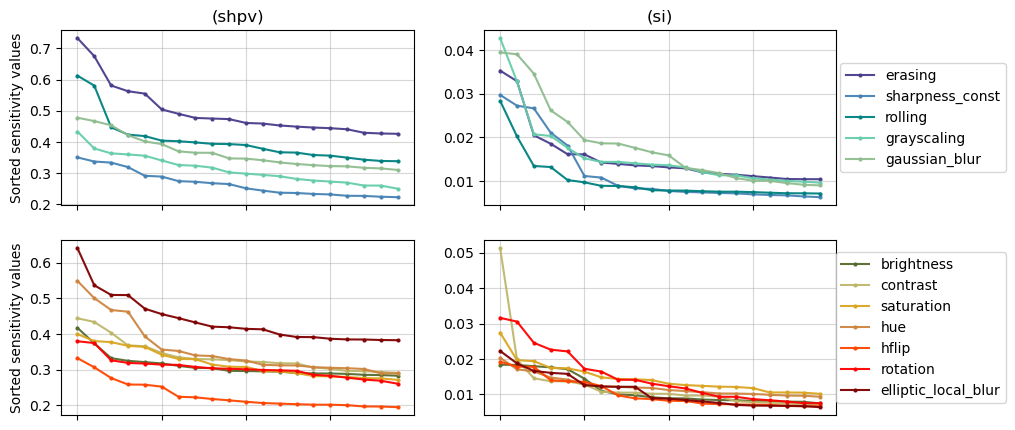

In [26]:
prediction.single_class.plot_top_sensitivity_values_decay(
    resnet18_loaded_sensitivity_values_dict_list,
    resnet18_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    n_top_values=n_top_values_decay_plot,
    figsize=figsize_decay_plot,
    extract_auxilliary_names=False,
    plot_colors=prediction.single_class._custom_colors[::-1],
    show=True,
)

### 3.3 Top sensitivity values and corresponding classes

[[$\leftarrow$Prev.subsect.]](#3.2-Decay-of-the-top-sensitivity-values)$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)

In [27]:
resnet18_table_dict = prediction.single_class.extract_tables_top_sensitivity_values_decay(
    resnet18_loaded_sensitivity_values_dict_list,
    resnet18_classifying_layer_name,
    sensitivity_values_name_list,
    augmentation_set_numbers_list,
    ilsvrc_dataset.ind2class,
    n_top_values=10,
    extract_auxilliary_names=False,
)

In [28]:
# upd
for aug_name in augmentation_names:
    print(f'\n\t\t\t Augmentation: {aug_name}')
    display(resnet18_table_dict[aug_name])


			 Augmentation: erasing


shpv                                                                si   
  class_id                                         class_name value class_id   
0      460  breakwater, groin, groyne, mole, bulwark, seaw...   .73       43  \
1      977                                  sandbar, sand bar   .67      894   
2      120                                       fiddler crab   .58      996   
3      419                                           Band Aid   .56      277   
4      899                                          water jug   .55       31   
5      788                   shoe shop, shoe-shop, shoe store   .50      695   
6       75                   black widow, Latrodectus mactans   .49      851   
7      673                              mouse, computer mouse   .48      664   
8       21                                               kite   .48      514   
9       29            axolotl, mud puppy, Ambystoma mexicanum   .47      604   

                                                            
                                          class_name value  
0               frilled lizard, Chlamydosaurus kingi   .04  
1                            wardrobe, closet, press   .03  
2  hen-of-the-woods, hen of the woods, Polyporus ...   .02  
3                             red fox, Vulpes vulpes   .02  
4                               tree frog, tree-frog   .02  
5                                            padlock   .02  
6                      television, television system   .01  
7                                            monitor   .01  
8                                        cowboy boot   .01  
9                                          hourglass   .01


			 Augmentation: sharpness_const


shpv                                             si   
  class_id                      class_name value class_id   
0      735                          poncho   .35      437  \
1      809                       soup bowl   .34      898   
2      305                     dung beetle   .33      217   
3      595               harvester, reaper   .32      281   
4      942                butternut squash   .29      374   
5      902                         whistle   .29       90   
6      492                           chest   .27      879   
7      264  Cardigan, Cardigan Welsh corgi   .27      794   
8      631                          lotion   .27      822   
9      311             grasshopper, hopper   .27      620   

                                                     
                                   class_name value  
0    beacon, lighthouse, beacon light, pharos   .03  
1                                water bottle   .03  
2  English springer, English springer spaniel   .03  
3                            tabby, tabby cat   .02  
4                                      langur   .02  
5                                    lorikeet   .01  
6                                    umbrella   .01  
7                              shower curtain   .01  
8                                  steel drum   .01  
9                     laptop, laptop computer   .01


			 Augmentation: rolling


shpv                                                                si   
  class_id                                         class_name value class_id   
0      935                                      mashed potato   .61      217  \
1      960                   chocolate sauce, chocolate syrup   .58      949   
2      478                                             carton   .45      210   
3      733                                               pole   .42      822   
4        2  great white shark, white shark, man-eater, man...   .42      810   
5      441                                         beer glass   .40      916   
6      748                                              purse   .40       73   
7      921  book jacket, dust cover, dust jacket, dust wra...   .40      877   
8      678                                         neck brace   .39      818   
9      138                                            bustard   .39      763   

                                                     
                                   class_name value  
0  English springer, English springer spaniel   .03  
1                                  strawberry   .02  
2                 German short-haired pointer   .01  
3                                  steel drum   .01  
4                                   space bar   .01  
5      web site, website, internet site, site   .01  
6              barn spider, Araneus cavaticus   .01  
7                                   turnstile   .01  
8                             spotlight, spot   .01  
9              revolver, six-gun, six-shooter   .01


			 Augmentation: grayscaling


shpv                                       si   
  class_id                class_name value class_id   
0      973                coral reef   .43      437  \
1      213  Irish setter, red setter   .38      743   
2      638                   maillot   .36      776   
3      809                 soup bowl   .36      747   
4      539      doormat, welcome mat   .36      424   
5      777                  scabbard   .34      281   
6      950                    orange   .33      587   
7      689                 overskirt   .32      677   
8      529     diaper, nappy, napkin   .32      217   
9      951                     lemon   .30      600   

                                                            
                                          class_name value  
0           beacon, lighthouse, beacon light, pharos   .04  
1                               prison, prison house   .03  
2                                     sax, saxophone   .02  
3  punching bag, punch bag, punching ball, punchball   .02  
4                                         barbershop   .02  
5                                   tabby, tabby cat   .02  
6                                             hammer   .01  
7                                               nail   .01  
8         English springer, English springer spaniel   .01  
9                                         hook, claw   .01


			 Augmentation: gaussian_blur


shpv                                                                si   
  class_id                                         class_name value class_id   
0      976               promontory, headland, head, foreland   .48      364  \
1       65                                          sea snake   .47      437   
2      252         affenpinscher, monkey pinscher, monkey dog   .45      217   
3      584                                         hair slide   .42      970   
4      301  ladybug, ladybeetle, lady beetle, ladybird, la...   .40       74   
5      797                                       sleeping bag   .39      435   
6      813                                            spatula   .37      770   
7      959                                          carbonara   .37      885   
8       55                           green snake, grass snake   .37      507   
9      313          walking stick, walkingstick, stick insect   .35      281   

                                                     
                                   class_name value  
0  three-toed sloth, ai, Bradypus tridactylus   .04  
1    beacon, lighthouse, beacon light, pharos   .04  
2  English springer, English springer spaniel   .03  
3                                         alp   .03  
4             garden spider, Aranea diademata   .02  
5             bathtub, bathing tub, bath, tub   .02  
6                                running shoe   .02  
7                                      velvet   .02  
8                            combination lock   .02  
9                            tabby, tabby cat   .02


			 Augmentation: brightness


shpv                                                                si   
  class_id                                         class_name value class_id   
0      722                                     ping-pong ball   .42      189  \
1      337                                             beaver   .37      881   
2      719                             piggy bank, penny bank   .33       87   
3       34  leatherback turtle, leatherback, leathery turt...   .32      494   
4      587                                             hammer   .32      407   
5       56                              king snake, kingsnake   .32      829   
6      454                     bookshop, bookstore, bookstall   .31      126   
7      811                                       space heater   .30      818   
8      330         wood rabbit, cottontail, cottontail rabbit   .30      644   
9      662                                              modem   .30      936   

                                                          
                                        class_name value  
0                                 Lakeland terrier   .02  
1                           upright, upright piano   .02  
2  African grey, African gray, Psittacus erithacus   .02  
3                                chime, bell, gong   .02  
4                                        ambulance   .02  
5   streetcar, tram, tramcar, trolley, trolley car   .01  
6                                           isopod   .01  
7                                  spotlight, spot   .01  
8                                       matchstick   .01  
9                                     head cabbage   .01


			 Augmentation: contrast


shpv                                                     si   
  class_id                              class_name value class_id   
0      529                   diaper, nappy, napkin   .44      511  \
1      542                               drumstick   .43      611   
2      491                     chain saw, chainsaw   .40      837   
3      967                                espresso   .37      592   
4      768                              rugby ball   .37      450   
5      666                                  mortar   .35      204   
6      125                             hermit crab   .33      818   
7      462                                   broom   .33      716   
8      623  letter opener, paper knife, paperknife   .33      596   
9      556                  fire screen, fireguard   .33      295   

                                                            
                                          class_name value  
0                                        convertible   .05  
1                                      jigsaw puzzle   .02  
2                   sunglasses, dark glasses, shades   .01  
3                   hard disc, hard disk, fixed disk   .01  
4                            bobsled, bobsleigh, bob   .01  
5                                  Lhasa, Lhasa apso   .01  
6                                    spotlight, spot   .01  
7                               picket fence, paling   .01  
8                                            hatchet   .01  
9  American black bear, black bear, Ursus america...   .01


			 Augmentation: saturation


shpv                                                          si   
  class_id                                   class_name value class_id   
0      680                                       nipple   .40      394  \
1      451               bolo tie, bolo, bola tie, bola   .38      971   
2        5   electric ray, crampfish, numbfish, torpedo   .38      578   
3      313    walking stick, walkingstick, stick insect   .37      634   
4      341      hog, pig, grunter, squealer, Sus scrofa   .36      685   
5      299                             meerkat, mierkat   .34      927   
6      596                                      hatchet   .33      499   
7      485                                    CD player   .33      246   
8      520                                    crib, cot   .31       23   
9      671  mountain bike, all-terrain bike, off-roader   .31      461   

                                                     
                                   class_name value  
0                                    sturgeon   .03  
1                                      bubble   .02  
2                                        gown   .02  
3                         lumbermill, sawmill   .02  
4  odometer, hodometer, mileometer, milometer   .02  
5                                      trifle   .02  
6              cleaver, meat cleaver, chopper   .01  
7                                  Great Dane   .01  
8                                     vulture   .01  
9                    breastplate, aegis, egis   .01


			 Augmentation: hue


shpv                                             si   
  class_id                      class_name value class_id   
0      977               sandbar, sand bar   .55      309  \
1      493             chiffonier, commode   .50      530   
2      694       paddlewheel, paddle wheel   .47      464   
3      419                        Band Aid   .46      819   
4      963                pizza, pizza pie   .39       74   
5      202     soft-coated wheaten terrier   .36      324   
6      263  Pembroke, Pembroke Welsh corgi   .35       92   
7      758                            reel   .34      107   
8      932                         pretzel   .34      508   
9      698                          palace   .33      837   

                                           
                         class_name value  
0                               bee   .02  
1                     digital clock   .02  
2                            buckle   .02  
3                             stage   .01  
4   garden spider, Aranea diademata   .01  
5                 cabbage butterfly   .01  
6                         bee eater   .01  
7                         jellyfish   .01  
8         computer keyboard, keypad   .01  
9  sunglasses, dark glasses, shades   .01


			 Augmentation: hflip


shpv                                                      si   
  class_id                               class_name value class_id   
0      842          swimming trunks, bathing trunks   .33      394  \
1      397  puffer, pufferfish, blowfish, globefish   .31      685   
2      801                                  snorkel   .28       30   
3      591      handkerchief, hankie, hanky, hankey   .26      619   
4      634                      lumbermill, sawmill   .26      829   
5      959                                carbonara   .25      963   
6      315                           mantis, mantid   .22      507   
7      982                        groom, bridegroom   .22      472   
8      748                                    purse   .22      183   
9      843                                    swing   .21      948   

                                                         
                                       class_name value  
0                                        sturgeon   .02  
1      odometer, hodometer, mileometer, milometer   .02  
2                      bullfrog, Rana catesbeiana   .02  
3                           lampshade, lamp shade   .01  
4  streetcar, tram, tramcar, trolley, trolley car   .01  
5                                pizza, pizza pie   .01  
6                                combination lock   .01  
7                                           canoe   .01  
8                              Kerry blue terrier   .01  
9                                    Granny Smith   .01


			 Augmentation: rotation


shpv                                                                si   
  class_id                                         class_name value class_id   
0      926                                    hot pot, hotpot   .38      487  \
1      789                                              shoji   .37      652   
2      469                                  caldron, cauldron   .33      868   
3      676                                             muzzle   .32      806   
4      351                                         hartebeest   .32      947   
5      133                                            bittern   .31      976   
6      964                                             potpie   .31      272   
7      271     red wolf, maned wolf, Canis rufus, Canis niger   .31        2   
8      921  book jacket, dust cover, dust jacket, dust wra...   .30      513   
9      589  hand blower, blow dryer, blow drier, hair drye...   .30      567   

                                                            
                                          class_name value  
0  cellular telephone, cellular phone, cellphone,...   .03  
1                                   military uniform   .03  
2                                               tray   .02  
3                                               sock   .02  
4                                           mushroom   .02  
5               promontory, headland, head, foreland   .02  
6    coyote, prairie wolf, brush wolf, Canis latrans   .02  
7  great white shark, white shark, man-eater, man...   .01  
8                       cornet, horn, trumpet, trump   .01  
9                        frying pan, frypan, skillet   .01


			 Augmentation: elliptic_local_blur


shpv                                                              si   
  class_id                                       class_name value class_id   
0      478                                           carton   .64      875  \
1      933                                     cheeseburger   .54      685   
2      209                         Chesapeake Bay retriever   .51      411   
3      809                                        soup bowl   .51      186   
4      158                                      toy terrier   .47      829   
5      362                                           badger   .46      487   
6       25  European fire salamander, Salamandra salamandra   .44      407   
7      305                                      dung beetle   .43      830   
8      869                                      trench coat   .42      499   
9      831                            studio couch, day bed   .42      596   

                                                            
                                          class_name value  
0                                           trombone   .02  
1         odometer, hodometer, mileometer, milometer   .02  
2                                              apron   .02  
3                                    Norwich terrier   .02  
4     streetcar, tram, tramcar, trolley, trolley car   .02  
5  cellular telephone, cellular phone, cellphone,...   .01  
6                                          ambulance   .01  
7                                          stretcher   .01  
8                     cleaver, meat cleaver, chopper   .01  
9                                            hatchet   .01

In [27]:
# was
for aug_name in augmentation_names:
    print(f'\n\t\t\t Augmentation: {aug_name}')
    display(resnet18_table_dict[aug_name])


			 Augmentation: erasing


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      460  breakwater, groin, groyne, mole, bulwark, seaw...   .73       43   
1      977                                  sandbar, sand bar   .67      894   
2      120                                       fiddler crab   .58      996   
3      419                                           Band Aid   .56      277   
4      899                                          water jug   .55       31   
5      788                   shoe shop, shoe-shop, shoe store   .50      695   
6       75                   black widow, Latrodectus mactans   .49      851   
7      673                              mouse, computer mouse   .48      664   
8       21                                               kite   .48      514   
9       29            axolotl, mud puppy, Ambystoma mexicanum   .47      604   

                                                            
                                          class_name value  
0               frilled lizard, Chlamydosaurus kingi   .04  
1                            wardrobe, closet, press   .03  
2  hen-of-the-woods, hen of the woods, Polyporus ...   .02  
3                             red fox, Vulpes vulpes   .02  
4                               tree frog, tree-frog   .02  
5                                            padlock   .02  
6                      television, television system   .01  
7                                            monitor   .01  
8                                        cowboy boot   .01  
9                                          hourglass   .01


			 Augmentation: sharpness_const


shpv                                             si  \
  class_id                      class_name value class_id   
0      735                          poncho   .35      437   
1      809                       soup bowl   .34      898   
2      305                     dung beetle   .33      217   
3      595               harvester, reaper   .32      281   
4      942                butternut squash   .29      374   
5      902                         whistle   .29       90   
6      492                           chest   .27      879   
7      264  Cardigan, Cardigan Welsh corgi   .27      794   
8      631                          lotion   .27      822   
9      311             grasshopper, hopper   .27      620   

                                                     
                                   class_name value  
0    beacon, lighthouse, beacon light, pharos   .03  
1                                water bottle   .03  
2  English springer, English springer spaniel   .03  
3                            tabby, tabby cat   .02  
4                                      langur   .02  
5                                    lorikeet   .01  
6                                    umbrella   .01  
7                              shower curtain   .01  
8                                  steel drum   .01  
9                     laptop, laptop computer   .01


			 Augmentation: rolling


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      935                                      mashed potato   .61      217   
1      960                   chocolate sauce, chocolate syrup   .58      949   
2      478                                             carton   .45      210   
3      733                                               pole   .42      822   
4        2  great white shark, white shark, man-eater, man...   .42      810   
5      441                                         beer glass   .40      916   
6      748                                              purse   .40       73   
7      921  book jacket, dust cover, dust jacket, dust wra...   .40      877   
8      678                                         neck brace   .39      818   
9      138                                            bustard   .39      763   

                                                     
                                   class_name value  
0  English springer, English springer spaniel   .03  
1                                  strawberry   .02  
2                 German short-haired pointer   .01  
3                                  steel drum   .01  
4                                   space bar   .01  
5      web site, website, internet site, site   .01  
6              barn spider, Araneus cavaticus   .01  
7                                   turnstile   .01  
8                             spotlight, spot   .01  
9              revolver, six-gun, six-shooter   .01


			 Augmentation: grayscaling


shpv                                       si  \
  class_id                class_name value class_id   
0      973                coral reef   .43      437   
1      213  Irish setter, red setter   .38      743   
2      638                   maillot   .36      776   
3      809                 soup bowl   .36      747   
4      539      doormat, welcome mat   .36      424   
5      777                  scabbard   .34      281   
6      950                    orange   .33      587   
7      689                 overskirt   .32      677   
8      529     diaper, nappy, napkin   .32      217   
9      951                     lemon   .30      600   

                                                            
                                          class_name value  
0           beacon, lighthouse, beacon light, pharos   .04  
1                               prison, prison house   .03  
2                                     sax, saxophone   .02  
3  punching bag, punch bag, punching ball, punchball   .02  
4                                         barbershop   .02  
5                                   tabby, tabby cat   .02  
6                                             hammer   .01  
7                                               nail   .01  
8         English springer, English springer spaniel   .01  
9                                         hook, claw   .01


			 Augmentation: gaussian_blur


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      976               promontory, headland, head, foreland   .48      364   
1       65                                          sea snake   .47      437   
2      252         affenpinscher, monkey pinscher, monkey dog   .45      217   
3      584                                         hair slide   .42      970   
4      301  ladybug, ladybeetle, lady beetle, ladybird, la...   .40       74   
5      797                                       sleeping bag   .39      435   
6      813                                            spatula   .37      770   
7      959                                          carbonara   .37      885   
8       55                           green snake, grass snake   .37      507   
9      313          walking stick, walkingstick, stick insect   .35      281   

                                                     
                                   class_name value  
0  three-toed sloth, ai, Bradypus tridactylus   .04  
1    beacon, lighthouse, beacon light, pharos   .04  
2  English springer, English springer spaniel   .03  
3                                         alp   .03  
4             garden spider, Aranea diademata   .02  
5             bathtub, bathing tub, bath, tub   .02  
6                                running shoe   .02  
7                                      velvet   .02  
8                            combination lock   .02  
9                            tabby, tabby cat   .02


			 Augmentation: brightness


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      722                                     ping-pong ball   .42      189   
1      337                                             beaver   .37      881   
2      719                             piggy bank, penny bank   .33       87   
3       34  leatherback turtle, leatherback, leathery turt...   .32      494   
4      587                                             hammer   .32      407   
5       56                              king snake, kingsnake   .32      829   
6      454                     bookshop, bookstore, bookstall   .31      126   
7      811                                       space heater   .30      818   
8      330         wood rabbit, cottontail, cottontail rabbit   .30      644   
9      662                                              modem   .30      936   

                                                          
                                        class_name value  
0                                 Lakeland terrier   .02  
1                           upright, upright piano   .02  
2  African grey, African gray, Psittacus erithacus   .02  
3                                chime, bell, gong   .02  
4                                        ambulance   .02  
5   streetcar, tram, tramcar, trolley, trolley car   .01  
6                                           isopod   .01  
7                                  spotlight, spot   .01  
8                                       matchstick   .01  
9                                     head cabbage   .01


			 Augmentation: contrast


shpv                                                     si  \
  class_id                              class_name value class_id   
0      529                   diaper, nappy, napkin   .44      511   
1      542                               drumstick   .43      611   
2      491                     chain saw, chainsaw   .40      837   
3      967                                espresso   .37      592   
4      768                              rugby ball   .37      450   
5      666                                  mortar   .35      204   
6      125                             hermit crab   .33      818   
7      462                                   broom   .33      716   
8      623  letter opener, paper knife, paperknife   .33      596   
9      556                  fire screen, fireguard   .33      295   

                                                            
                                          class_name value  
0                                        convertible   .05  
1                                      jigsaw puzzle   .02  
2                   sunglasses, dark glasses, shades   .01  
3                   hard disc, hard disk, fixed disk   .01  
4                            bobsled, bobsleigh, bob   .01  
5                                  Lhasa, Lhasa apso   .01  
6                                    spotlight, spot   .01  
7                               picket fence, paling   .01  
8                                            hatchet   .01  
9  American black bear, black bear, Ursus america...   .01


			 Augmentation: saturation


shpv                                                          si  \
  class_id                                   class_name value class_id   
0      680                                       nipple   .40      394   
1      451               bolo tie, bolo, bola tie, bola   .38      971   
2        5   electric ray, crampfish, numbfish, torpedo   .38      578   
3      313    walking stick, walkingstick, stick insect   .37      634   
4      341      hog, pig, grunter, squealer, Sus scrofa   .36      685   
5      299                             meerkat, mierkat   .34      927   
6      596                                      hatchet   .33      499   
7      485                                    CD player   .33      246   
8      520                                    crib, cot   .31       23   
9      671  mountain bike, all-terrain bike, off-roader   .31      461   

                                                     
                                   class_name value  
0                                    sturgeon   .03  
1                                      bubble   .02  
2                                        gown   .02  
3                         lumbermill, sawmill   .02  
4  odometer, hodometer, mileometer, milometer   .02  
5                                      trifle   .02  
6              cleaver, meat cleaver, chopper   .01  
7                                  Great Dane   .01  
8                                     vulture   .01  
9                    breastplate, aegis, egis   .01


			 Augmentation: hue


shpv                                             si  \
  class_id                      class_name value class_id   
0      977               sandbar, sand bar   .55      309   
1      493             chiffonier, commode   .50      530   
2      694       paddlewheel, paddle wheel   .47      464   
3      419                        Band Aid   .46      819   
4      963                pizza, pizza pie   .39       74   
5      202     soft-coated wheaten terrier   .36      324   
6      263  Pembroke, Pembroke Welsh corgi   .35       92   
7      758                            reel   .34      107   
8      932                         pretzel   .34      508   
9      698                          palace   .33      837   

                                           
                         class_name value  
0                               bee   .02  
1                     digital clock   .02  
2                            buckle   .02  
3                             stage   .01  
4   garden spider, Aranea diademata   .01  
5                 cabbage butterfly   .01  
6                         bee eater   .01  
7                         jellyfish   .01  
8         computer keyboard, keypad   .01  
9  sunglasses, dark glasses, shades   .01


			 Augmentation: hflip


shpv                                                      si  \
  class_id                               class_name value class_id   
0      842          swimming trunks, bathing trunks   .33      394   
1      397  puffer, pufferfish, blowfish, globefish   .31      685   
2      801                                  snorkel   .28       30   
3      591      handkerchief, hankie, hanky, hankey   .26      619   
4      634                      lumbermill, sawmill   .26      829   
5      959                                carbonara   .25      963   
6      315                           mantis, mantid   .22      507   
7      982                        groom, bridegroom   .22      472   
8      748                                    purse   .22      183   
9      843                                    swing   .21      948   

                                                         
                                       class_name value  
0                                        sturgeon   .02  
1      odometer, hodometer, mileometer, milometer   .02  
2                      bullfrog, Rana catesbeiana   .02  
3                           lampshade, lamp shade   .01  
4  streetcar, tram, tramcar, trolley, trolley car   .01  
5                                pizza, pizza pie   .01  
6                                combination lock   .01  
7                                           canoe   .01  
8                              Kerry blue terrier   .01  
9                                    Granny Smith   .01


			 Augmentation: rotation


shpv                                                                si  \
  class_id                                         class_name value class_id   
0      926                                    hot pot, hotpot   .38      487   
1      789                                              shoji   .37      652   
2      469                                  caldron, cauldron   .33      868   
3      676                                             muzzle   .32      806   
4      351                                         hartebeest   .32      947   
5      133                                            bittern   .31      976   
6      964                                             potpie   .31      272   
7      271     red wolf, maned wolf, Canis rufus, Canis niger   .31        2   
8      921  book jacket, dust cover, dust jacket, dust wra...   .30      513   
9      589  hand blower, blow dryer, blow drier, hair drye...   .30      567   

                                                            
                                          class_name value  
0  cellular telephone, cellular phone, cellphone,...   .03  
1                                   military uniform   .03  
2                                               tray   .02  
3                                               sock   .02  
4                                           mushroom   .02  
5               promontory, headland, head, foreland   .02  
6    coyote, prairie wolf, brush wolf, Canis latrans   .02  
7  great white shark, white shark, man-eater, man...   .01  
8                       cornet, horn, trumpet, trump   .01  
9                        frying pan, frypan, skillet   .01


			 Augmentation: elliptic_local_blur


shpv                                                              si  \
  class_id                                       class_name value class_id   
0      478                                           carton   .64      875   
1      933                                     cheeseburger   .54      685   
2      209                         Chesapeake Bay retriever   .51      411   
3      809                                        soup bowl   .51      186   
4      158                                      toy terrier   .47      829   
5      362                                           badger   .46      487   
6       25  European fire salamander, Salamandra salamandra   .44      407   
7      305                                      dung beetle   .43      830   
8      869                                      trench coat   .42      499   
9      831                            studio couch, day bed   .42      596   

                                                            
                                          class_name value  
0                                           trombone   .02  
1         odometer, hodometer, mileometer, milometer   .02  
2                                              apron   .02  
3                                    Norwich terrier   .02  
4     streetcar, tram, tramcar, trolley, trolley car   .02  
5  cellular telephone, cellular phone, cellphone,...   .01  
6                                          ambulance   .01  
7                                          stretcher   .01  
8                     cleaver, meat cleaver, chopper   .01  
9                                            hatchet   .01

### 3.4 Jaccard indices for top-5 predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#3.3-Top-sensitivity-values-and-corresponding-classes)$\quad$[[Back to section]](#3.-ResNet18)$\quad$[[Next subsect.$\to$]](#3.5-Jaccard-indices-for-top-5-masked-predictions-and-top-5-sensitive-classes)

In [29]:
resnet18_sensitivity_topn_list = prediction.single_class.get_sensitivity_topn_dict(
    resnet18_loaded_sensitivity_values_dict_list,
    resnet18_classifying_layer_name,
    augmentation_set_numbers_list,
    top_n=5,
    extract_auxilliary_names=False,
)

resnet18_results_jacc_nofcl_list = []
resnet18_results_jacc_aug_no_mask_list = []
resnet18_results_jacc_orig_no_mask_list = []

for i in range(n_sens_vals):
    (
        resnet18_results_jacc,
        resnet18_results_jacc_aug_no_mask,
        resnet18_results_jacc_orig_no_mask,
    ) = prediction.single_class.extract_jaccard(
        prediction_results_path_nofcl_list[i],
        resnet18_sensitivity_topn_list[i],
        augmentation_names,
        no_aug_key=no_aug_key,
        y_true_key=y_true_key,
    )
    resnet18_results_jacc_nofcl_list.append(resnet18_results_jacc)
    resnet18_results_jacc_aug_no_mask_list.append(resnet18_results_jacc_aug_no_mask)
    resnet18_results_jacc_orig_no_mask_list.append(resnet18_results_jacc_orig_no_mask)

Nsamples=50000
Nsamples=50000


In [34]:
for i_val, val_name in enumerate(sensitivity_values_name_list):
    table_jac_no_masking = prediction.single_class.extract_table_no_masking(
        resnet18_results_jacc_aug_no_mask_list[i_val],
        resnet18_results_jacc_orig_no_mask_list[i_val],
        augmentation_set_numbers_list,
        extract_auxilliary_names=False,
        n_round_digits=n_round_digits,
        no_aug_key=no_aug_key,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table_jac_no_masking)



				shpv


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0034                                     \
erasing                                                           0.0035                                      
sharpness_const                                                   0.0035                                      
rolling                                                           0.0029                                      
grayscaling                                                       0.0033                                      
gaussian_blur                                                     0.0032                                      
brightness                                                        0.0029                                      
contrast                                                          0.0028                                      
saturation                                                        0.0030                                      
hue                                                               0.0028                                      
hflip                                                             0.0033                                      
rotation                                                          0.0030                                      
elliptic_local_blur                                               0.0034                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0028  0.0031      0.0033        0.0023  \
erasing                        0.0021  0.0032      0.0027        0.0017   
sharpness_const                0.0028  0.0032      0.0034        0.0021   
rolling                        0.0025  0.0032      0.0030        0.0019   
grayscaling                    0.0017  0.0023      0.0022        0.0018   
gaussian_blur                  0.0025  0.0026      0.0028        0.0030   
brightness                     0.0026  0.0032      0.0032        0.0026   
contrast                       0.0024  0.0034      0.0030        0.0022   
saturation                     0.0032  0.0028      0.0038        0.0024   
hue                            0.0028  0.0023      0.0039        0.0032   
hflip                          0.0028  0.0032      0.0033        0.0023   
rotation                       0.0029  0.0034      0.0033        0.0030   
elliptic_local_blur            0.0029  0.0032      0.0034        0.0024   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0036   0.0026     0.0026  0.0020  0.0030   0.0027  \
erasing                   0.0028   0.0018     0.0021  0.0018  0.0022   0.0027   
sharpness_const           0.0036   0.0024     0.0025  0.0019  0.0028   0.0025   
rolling                   0.0034   0.0023     0.0023  0.0019  0.0032   0.0024   
grayscaling               0.0047   0.0024     0.0024  0.0016  0.0021   0.0024   
gaussian_blur             0.0031   0.0028     0.0031  0.0020  0.0029   0.0036   
brightness                0.0033   0.0023     0.0023  0.0019  0.0030   0.0026   
contrast                  0.0031   0.0026     0.0020  0.0017  0.0022   0.0025   
saturation                0.0036   0.0023     0.0024  0.0019  0.0029   0.0026   
hue                       0.0032   0.0016     0.0027  0.0012  0.0028   0



				si


SA variable used for extracting the most sensitive classes from the classifying layer   
                                                                                                    erasing   
Augmentation of input                                                                                         
original                                                          0.0027                                     \
erasing                                                           0.0023                                      
sharpness_const                                                   0.0025                                      
rolling                                                           0.0027                                      
grayscaling                                                       0.0020                                      
gaussian_blur                                                     0.0027                                      
brightness                                                        0.0025                                      
contrast                                                          0.0025                                      
saturation                                                        0.0028                                      
hue                                                               0.0023                                      
hflip                                                             0.0026                                      
rotation                                                          0.0026                                      
elliptic_local_blur                                               0.0027                                      

                                                                          
                      sharpness_const rolling grayscaling gaussian_blur   
Augmentation of input                                                     
original                       0.0031  0.0023      0.0032        0.0027  \
erasing                        0.0038  0.0021      0.0051        0.0032   
sharpness_const                0.0031  0.0022      0.0033        0.0028   
rolling                        0.0032  0.0024      0.0037        0.0029   
grayscaling                    0.0031  0.0019      0.0062        0.0026   
gaussian_blur                  0.0028  0.0028      0.0037        0.0026   
brightness                     0.0028  0.0022      0.0031        0.0028   
contrast                       0.0030  0.0022      0.0041        0.0029   
saturation                     0.0031  0.0022      0.0034        0.0026   
hue                            0.0039  0.0023      0.0030        0.0027   
hflip                          0.0031  0.0023      0.0032        0.0027   
rotation                       0.0027  0.0025      0.0034        0.0033   
elliptic_local_blur            0.0031  0.0023      0.0034        0.0028   

                                                                                
                      brightness contrast saturation     hue   hflip rotation   
Augmentation of input                                                           
original                  0.0029   0.0023     0.0027  0.0033  0.0028   0.0037  \
erasing                   0.0034   0.0021     0.0024  0.0040  0.0026   0.0036   
sharpness_const           0.0029   0.0025     0.0026  0.0034  0.0027   0.0038   
rolling                   0.0030   0.0023     0.0027  0.0034  0.0027   0.0036   
grayscaling               0.0027   0.0022     0.0032  0.0027  0.0028   0.0039   
gaussian_blur             0.0033   0.0023     0.0027  0.0031  0.0024   0.0030   
brightness                0.0032   0.0028     0.0028  0.0041  0.0029   0.0035   
contrast                  0.0030   0.0026     0.0030  0.0054  0.0033   0.0034   
saturation                0.0030   0.0024     0.0026  0.0037  0.0027   0.0037   
hue                       0.0027   0.0022     0.0030  0.0049  0.0026   0

### 3.5 Jaccard indices for top-5 masked predictions and top-5 sensitive classes

[[$\leftarrow$Prev.subsect.]](#3.4-Jaccard-indices-for-top-5-predictions-and-top-5-sensitive-classes)$\quad$[[Back to section]](#3.-ResNet18)$\quad$

In [35]:
for i_val, val_name in enumerate(sensitivity_values_name_list):
    featured_measurements, _ = prediction.single_class.collect_featured_measurements_jac(
        resnet18_results_jacc_nofcl_list[i_val],
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        no_aug_key=no_aug_key,
    )
    table = prediction.single_class.extract_table_self_masking(
        featured_measurements,
        augmentation_set_numbers_list,
        alphas,
        percentiles,
        inverts,
        n_round_digits=n_round_digits,
        extract_auxilliary_names=False,
    )
    print(f'\n\n\t\t\t\t{val_name}')
    display(table)



				shpv


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0001            \
sharpness_const                                                   0.0000             
rolling                                                           0.0000             
grayscaling                                                       0.0000             
gaussian_blur                                                     0.0000             
brightness                                                        0.0000             
contrast                                                          0.0000             
saturation                                                        0.0000             
hue                                                               0.0066             
hflip                                                             0.0000             
rotation                                                          0.0000             
elliptic_local_blur                                               0.0000             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0001  0.0001  0.0007  0.0021    0.0007  0.0011  \
sharpness_const        0.0000  0.0000  0.0000  0.0004    0.0049  0.0003   
rolling                0.0046  0.0083  0.0034  0.0029    0.0050  0.0054   
grayscaling            0.0000  0.0011  0.0022  0.0028    0.0013  0.0014   
gaussian_blur          0.0000  0.0000  0.0001  0.0011    0.0011  0.0017   
brightness             0.0000  0.0002  0.0046  0.0036    0.0008  0.0021   
contrast               0.0000  0.0001  0.0006  0.0014    0.0002  0.0006   
saturation             0.0000  0.0001  0.0021  0.0026    0.0006  0.0011   
hue                    0.0033  0.0009  0.0013  0.0013    0.0005  0.0010   
hflip                  0.0000  0.0001  0.0001  0.0005    0.0009  0.0010   
rotation               0.0001  0.0012  0.0031  0.0025    0.0007  0.0020   
elliptic_local_blur    0.0001  0.0022  0.0040  0.0063    0.0025  0.0047   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0016  0.0021  0.0028    0.0023  0.0035  0.0042  \
sharpness_const        0.0004  0.0011  0.0021    0.0000  0.0001  0.0003   
rolling                0.0042  0.0037  0.0031    0.0013  0.0023  0.0023   
grayscaling            0.0014  0.0016  0.0020    0.0018  0.0026  0.0052   
gaussian_blur          0.0022  0.0021  0.0023    0.0030  0.0027  0.0037   
brightness             0.0036  0.0038  0.0033    0.0001  0.0001  0.0003   
contrast               0.0010  0.0014  0.0021    0.0001  0.0002  0.0005   
saturation             0.0025  0.0032  0.0030    0.0003  0.0004  0.0005   
hue                    0.0013  0.0014  0.0014    0.0001  0.0002  0.0004   
hflip                  0.0013  0.0016  0.0023    0.0002  0.0004  0.0010   
rotation               0.0022  0.0023  0.0024    0.0009  0.0009  0.0009   
elliptic_local_blur    0.0056  0.0044  0.0034    0.0002  0.0006  0.0012   

                                                     
                                      inv=0   inv=1  
                        q=0.8   q=0.9                
Augmentation of input                                
erasing                0.00



				si


Mask configuration (SA variable is the same as augmentation)   
                                                                         alpha=0.0   
                                                                             q=0.5   
Augmentation of input                                                                
erasing                                                           0.0000            \
sharpness_const                                                   0.0000             
rolling                                                           0.0000             
grayscaling                                                       0.0000             
gaussian_blur                                                     0.0006             
brightness                                                        0.0000             
contrast                                                          0.0289             
saturation                                                        0.0000             
hue                                                               0.0000             
hflip                                                             0.0000             
rotation                                                          0.0034             
elliptic_local_blur                                               0.0000             

                                                                          
                                                      alpha=0.5           
                        q=0.6   q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   
Augmentation of input                                                     
erasing                0.0001  0.0012  0.0047  0.0019    0.0008  0.0011  \
sharpness_const        0.0008  0.0002  0.0001  0.0014    0.0025  0.0025   
rolling                0.0001  0.0002  0.0004  0.0018    0.0009  0.0015   
grayscaling            0.0008  0.0044  0.0059  0.0030    0.0006  0.0016   
gaussian_blur          0.0000  0.0000  0.0002  0.0008    0.0005  0.0010   
brightness             0.0000  0.0004  0.0012  0.0027    0.0008  0.0014   
contrast               0.0803  0.0727  0.0234  0.0072    0.0382  0.0293   
saturation             0.0000  0.0000  0.0010  0.0015    0.0015  0.0026   
hue                    0.0000  0.0004  0.0013  0.0019    0.0005  0.0009   
hflip                  0.0000  0.0000  0.0009  0.0026    0.0000  0.0021   
rotation               0.0042  0.0001  0.0005  0.0028    0.0015  0.0020   
elliptic_local_blur    0.0000  0.0000  0.0019  0.0018    0.0001  0.0010   

                                                                          
                                              alpha=1.5                   
                        q=0.7   q=0.8   q=0.9     q=0.5   q=0.6   q=0.7   
Augmentation of input                                                     
erasing                0.0020  0.0030  0.0026    0.0000  0.0000  0.0001  \
sharpness_const        0.0025  0.0028  0.0031    0.0009  0.0013  0.0022   
rolling                0.0018  0.0030  0.0022    0.0002  0.0005  0.0010   
grayscaling            0.0032  0.0042  0.0036    0.0039  0.0024  0.0018   
gaussian_blur          0.0018  0.0021  0.0020    0.0002  0.0002  0.0004   
brightness             0.0020  0.0024  0.0031    0.0003  0.0004  0.0008   
contrast               0.0184  0.0079  0.0035    0.0037  0.0070  0.0095   
saturation             0.0038  0.0032  0.0026    0.0054  0.0113  0.0169   
hue                    0.0014  0.0021  0.0025    0.0425  0.0403  0.0345   
hflip                  0.0026  0.0032  0.0033    0.0574  0.0233  0.0132   
rotation               0.0028  0.0038  0.0032    0.0045  0.0047  0.0049   
elliptic_local_blur    0.0016  0.0022  0.0024    0.0044  0.0044  0.0049   

                                                     
                                      inv=0   inv=1  
                        q=0.8   q=0.9                
Augmentation of input                                
erasing                0.00